# Universal FirstBar Strategy - Professional Analysis System

## Executive Summary

This notebook implements a **Universal FirstBar Trading Strategy analysis** with professional parameter optimization, train/test validation, and Sortino-focused investment decisions.

### Key Features:
- **🎯 Universal Ticker Support**: Test ANY ticker - just change `STRATEGY_TICKER` variable
- **🔬 Parameter Optimization**: Automatically discovers optimal profit targets (0.5% to 4.0%) and strategy modes
- **📊 Train/Test Validation**: 70/30 split prevents overfitting, ensures realistic performance expectations  
- **⭐ Sortino-Based Decisions**: Investment recommendations based on downside risk management
- **📈 Comprehensive Benchmarking**: Compare against buy-and-hold strategies
- **🏛️ Professional Reporting**: Training optimization + out-of-sample test results
- **🔌 IBKR Integration**: Live data from Interactive Brokers TWS API

### Universal Strategy Logic:
- **Signal Generation**: First hourly bar direction determines trade (bullish/bearish momentum)
- **Entry**: Close of first trading hour (15:30 ET)
- **Exit**: Profit target achievement OR end-of-day close
- **Parameter Discovery**: Automatically finds optimal profit target per ticker
- **Risk Management**: Same-day exits eliminate overnight gap risk

### Scientific Methodology:
- **Training Phase (70%)**: Parameter optimization on historical data
- **Testing Phase (30%)**: Out-of-sample validation with optimal parameters
- **No Overfitting**: Results based on unseen test data only
- **Sortino Optimization**: Focuses on downside deviation, not total volatility

### Investment Framework (Based on Out-of-Sample Sortino):
- **🟢 Strong Buy**: Sortino > 1.2 (excellent downside protection)
- **🟡 Moderate Buy**: Sortino > 0.8 (good downside management)
- **🟡 Hold/Monitor**: Sortino > 0.5 (acceptable downside risk)
- **🔴 Review/Reassess**: Sortino < 0.5 (poor downside protection)

### Easy Ticker Testing:
```python
STRATEGY_TICKER = "SPY"    # or "QQQ", "AAPL", "MSFT", "TQQQ", etc.
```
System automatically:
- Optimizes parameters for that specific ticker
- Validates performance on out-of-sample data  
- Provides Sortino-based investment recommendation
- Generates professional reports and analysis

---

## 🔧 Professional Configuration System

In [36]:
# ===================================================================
# UNIVERSAL TRADING SYSTEM CONFIGURATION
# ===================================================================

# === PRIMARY STRATEGY CONFIGURATION (EASILY CHANGEABLE) ===
STRATEGY_TICKER = "QQQ"             # 🎯 CHANGE THIS TO TEST ANY TICKER (QQQ, SPY, TQQQ, AAPL, etc.)
BENCHMARK_TICKERS = ["QQQ", "TQQQ", "SPY"]  # Flexible benchmark comparison assets
STRATEGY_MODE = "both"              # "buy", "sell", "both" (OPTIMAL: both sides)

# === PARAMETER OPTIMIZATION SETTINGS ===
PROFIT_TARGET_RANGE = [0.5, 0.8, 1.0, 1.2, 1.5, 1.8, 2.0, 2.2, 2.5, 2.8, 3.0, 3.5, 4.0]  # Test range
STRATEGY_MODES_TO_TEST = ["both", "buy", "sell"]  # Test different trade directions
OPTIMIZATION_METRIC = "sortino_ratio"  # Primary metric for parameter selection
SMA_FILTER = 0                      # 0 = disabled (matches original)

# === INDIVIDUAL STRATEGY PARAMETERS (FROM OPTIMIZATION) ===
PROFIT_TARGET = 2.2                 # Optimal profit target from testing
# Note: STRATEGY_MODE already defined above


# === TRAIN/TEST SPLIT CONFIGURATION ===
TRAIN_TEST_SPLIT = 1.0              # Use 100% of data (disable train/test split)
MINIMUM_TRAINING_DAYS = 500        # Minimum days required for training
MINIMUM_TESTING_DAYS = 200         # Minimum days required for testing

# === PORTFOLIO SIMULATION SETTINGS ===
INITIAL_CAPITAL = 100000            # Starting portfolio value ($100,000)
POSITION_SIZE_PCT = 1.0             # Position size as % of portfolio (1% = conservative)
TRANSACTION_COST_PER_SHARE = 0.005  # Transaction cost per share ($0.005)
SLIPPAGE_BPS = 2                    # Slippage in basis points (2 bps = 0.02%)

# === IBKR CONNECTION SETTINGS ===
TWS_HOST = "127.0.0.1"
TWS_PORT = 7497                     # 7497 = Paper, 7496 = Live
CLIENT_ID = 2                       # Unique client ID for this analysis

# === DATA CONFIGURATION ===
DATA_PERIOD = "3 Y"                 # Historical data period
BAR_SIZE = "1 hour"                 # Bar size for analysis
EXCHANGE = "SMART"                  # Smart routing
CURRENCY = "USD"

# === REPORTING SETTINGS ===
REPORT_TITLE = "Universal FirstBar Strategy Analysis"
ANALYST_NAME = "FirstBar Quantitative Research"
REPORT_DATE = "2025-09-25"

print(f"🏛️ {REPORT_TITLE} - Universal Configuration Loaded")
print(f"📊 Primary Asset: {STRATEGY_TICKER} (FLEXIBLE - easily changeable)")
print(f"📊 Benchmarks: {', '.join(BENCHMARK_TICKERS)}")
print(f"💰 Portfolio: ${INITIAL_CAPITAL:,} | Position Size: {POSITION_SIZE_PCT}%")
print(f"🎯 Parameter Optimization: {len(PROFIT_TARGET_RANGE)} profit targets × {len(STRATEGY_MODES_TO_TEST)} modes")
print(f"📊 Train/Test Split: {TRAIN_TEST_SPLIT*100:.0f}% training, {(1-TRAIN_TEST_SPLIT)*100:.0f}% testing")
print(f"⭐ Optimization Metric: {OPTIMIZATION_METRIC.replace('_', ' ').title()} (downside risk focus)")
print(f"🔌 IBKR: {TWS_HOST}:{TWS_PORT}")
print(f"\n💡 To test different assets: Simply change STRATEGY_TICKER to any ticker symbol!")

🏛️ Universal FirstBar Strategy Analysis - Universal Configuration Loaded
📊 Primary Asset: QQQ (FLEXIBLE - easily changeable)
📊 Benchmarks: QQQ, TQQQ, SPY
💰 Portfolio: $100,000 | Position Size: 1.0%
🎯 Parameter Optimization: 13 profit targets × 3 modes
📊 Train/Test Split: 100% training, 0% testing
⭐ Optimization Metric: Sortino Ratio (downside risk focus)
🔌 IBKR: 127.0.0.1:7497

💡 To test different assets: Simply change STRATEGY_TICKER to any ticker symbol!


## 📚 Professional Imports and Setup

In [37]:
# === CORE LIBRARIES ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from datetime import datetime, timedelta
import asyncio
import time
from typing import Dict, List, Tuple, Optional

# === STATISTICAL LIBRARIES ===
from scipy import stats
from scipy.stats import skew, kurtosis
import matplotlib.dates as mdates
from matplotlib.backends.backend_pdf import PdfPages

# === JUPYTER NOTEBOOK OPTIMIZATION ===
import nest_asyncio
nest_asyncio.apply()

# === IBKR INTEGRATION ===
try:
    from ib_insync import *
    IBKR_AVAILABLE = True
    print("✅ ib_insync imported successfully")
except ImportError:
    IBKR_AVAILABLE = False
    print("❌ ib_insync not available - limited functionality")

# === DISPLAY CONFIGURATION ===
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# === GLOBAL CONSTANTS ===
TRADING_DAYS_PER_YEAR = 252
RISK_FREE_RATE = 0.02  # 2% risk-free rate

print("📦 Professional libraries loaded successfully")
print(f"🕒 Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Jupyter asyncio optimization applied")

✅ ib_insync imported successfully
📦 Professional libraries loaded successfully
🕒 Analysis started: 2025-09-25 16:26:38
🎯 Jupyter asyncio optimization applied


## 🏗️ Professional Data Management System

In [38]:
class ProfessionalDataManager:
    """Professional-grade data management system for multi-asset analysis with automatic CSV export."""
    
    def __init__(self, host: str = TWS_HOST, port: int = TWS_PORT, client_id: int = CLIENT_ID):
        self.host = host
        self.port = port
        self.client_id = client_id
        self.ib = None
        self.connected = False
        self.data_cache = {}
        
    def connect(self) -> bool:
        """Establish professional IBKR connection with enhanced error handling."""
        if not IBKR_AVAILABLE:
            print("❌ IBKR not available - cannot establish connection")
            return False
            
        try:
            print(f"🔌 Establishing IBKR connection to {self.host}:{self.port}...")
            
            self.ib = IB()
            self.ib.connect(self.host, self.port, clientId=self.client_id, timeout=15)
            self.ib.sleep(2)  # Allow connection stabilization
            
            self.connected = True
            print(f"✅ Professional connection established (Client ID: {self.client_id})")
            
            # Validate connection with account information
            try:
                accounts = self.ib.managedAccounts()
                if accounts:
                    print(f"🏦 Connected to {len(accounts)} account(s)")
                    print(f"📊 Market data permissions verified")
                else:
                    print("⚠️ No account information available (may be normal for some setups)")
            except Exception as e:
                print(f"⚠️ Account info unavailable: {str(e)[:100]}")
            
            return True
            
        except Exception as e:
            print(f"❌ Connection failed: {e}")
            print("💡 Professional troubleshooting checklist:")
            print("   1. TWS/IB Gateway running and API enabled")
            print("   2. Correct port (7497=Paper, 7496=Live)")
            print("   3. Client ID not in use")
            print("   4. Market data subscriptions active")
            print("   5. Firewall settings allow connection")
            self.connected = False
            return False
    
    def create_professional_contract(self, symbol: str) -> Contract:
        """Create professionally configured IBKR contract."""
        # ETF and major equity configurations
        major_etfs = {
            'QQQ': ('STK', 'NASDAQ', 'USD'),
            'TQQQ': ('STK', 'NASDAQ', 'USD'),
            'SPY': ('STK', 'ARCA', 'USD'),
            'IWM': ('STK', 'ARCA', 'USD'),
            'DIA': ('STK', 'ARCA', 'USD')
        }
        
        if symbol.upper() in major_etfs:
            sec_type, exchange, currency = major_etfs[symbol.upper()]
            contract = Stock(symbol.upper(), exchange, currency)
        else:
            # Default configuration
            contract = Stock(symbol.upper(), EXCHANGE, CURRENCY)
        
        return contract
    
    def _create_organized_folders(self):
        """Create organized folder structure for data and results."""
        import os
        
        folders = [
            "../data/market_data",
            "../data/market_data/hourly",
            "../data/market_data/daily", 
            "../results/strategy_analysis",
            "../results/strategy_analysis/trades",
            "../results/strategy_analysis/equity_curves",
            "../results/strategy_analysis/performance_metrics",
            "../results/benchmark_analysis",
            "../reports/detailed_reports",
            "../reports/executive_summaries",
            "../reports/sortino_analysis"
        ]
        
        for folder in folders:
            os.makedirs(folder, exist_ok=True)
    
    def _export_to_csv(self, df: pd.DataFrame, symbol: str, duration: str, bar_size: str) -> str:
        """Export DataFrame to organized CSV structure with professional naming convention."""
        try:
            # Ensure organized folder structure exists
            self._create_organized_folders()
            
            # Create filename with timestamp and parameters
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            duration_clean = duration.replace(' ', '').lower()
            bar_clean = bar_size.replace(' ', '_').lower()
            
            # Organize by bar size
            if 'hour' in bar_clean:
                subfolder = "hourly"
            elif 'day' in bar_clean:
                subfolder = "daily"
            else:
                subfolder = "other"
            
            filename = f"../data/market_data/{subfolder}/{symbol.upper()}_MarketData_{duration_clean}_{bar_clean}_{timestamp}.csv"
            
            # Reset index to include datetime as column for CSV export
            export_df = df.reset_index()
            
            # Save to CSV
            export_df.to_csv(filename, index=False)
            print(f"💾 Market data exported: {filename}")
            
            return filename
            
        except Exception as e:
            print(f"⚠️ CSV export failed for {symbol}: {e}")
            return ""
    
    def fetch_professional_data(self, symbol: str, duration: str = DATA_PERIOD,
                              bar_size: str = BAR_SIZE, save_csv: bool = True) -> Optional[pd.DataFrame]:
        """Fetch professional-grade historical data with comprehensive validation and automatic CSV export."""
        if not self.connected:
            print(f"❌ Not connected to IBKR for {symbol}")
            return None

        try:
            print(f"📡 Fetching professional data for {symbol}...")

            # Create and qualify contract
            contract = self.create_professional_contract(symbol)
            qualified = self.ib.qualifyContracts(contract)

            if not qualified:
                print(f"❌ Contract qualification failed for {symbol}")
                return None

            contract = qualified[0]
            print(f"✅ Contract qualified: {contract.symbol} {contract.primaryExchange or contract.exchange}")

            # Request historical data with professional settings
            bars = self.ib.reqHistoricalData(
                contract,
                endDateTime='',
                durationStr=duration,
                barSizeSetting=bar_size,
                whatToShow='TRADES',
                useRTH=True,  # Regular trading hours
                formatDate=1,
                keepUpToDate=False
            )

            if not bars:
                print(f"❌ No data received for {symbol}")
                return None

            print(f"✅ Received {len(bars):,} bars for {symbol}")

            # Convert to professional DataFrame
            df = util.df(bars)

            if df.empty:
                print(f"❌ DataFrame conversion failed for {symbol}")
                return None

            # Professional data processing
            df = self._process_professional_data(df, symbol)

            # Automatic CSV export for transferability with organized structure
            if save_csv:
                csv_file = self._export_to_csv(df, symbol, duration, bar_size)
                if csv_file:
                    print(f"📁 Data saved in organized structure for transferability and reuse")

            # Cache data for efficiency
            self.data_cache[symbol] = df.copy()

            print(f"📊 {symbol} data processed: {len(df)} bars")
            print(f"📅 Period: {df.index[0].date()} to {df.index[-1].date()}")
            print(f"💰 Price range: ${df['close'].min():.2f} - ${df['close'].max():.2f}")

            return df

        except Exception as e:
            print(f"❌ Data fetch failed for {symbol}: {e}")
            return None
    
    def _process_professional_data(self, df: pd.DataFrame, symbol: str) -> pd.DataFrame:
        """Process data with professional standards."""
        # Standardize columns
        if 'date' in df.columns:
            df = df.rename(columns={'date': 'datetime'})
        
        # Ensure datetime index
        if 'datetime' in df.columns:
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.set_index('datetime')
        
        # Ensure required columns exist
        required_cols = ['open', 'high', 'low', 'close', 'volume']
        for col in required_cols:
            if col not in df.columns:
                print(f"⚠️ Missing column {col} for {symbol}")
        
        # Add professional calculations
        df['returns'] = df['close'].pct_change()
        df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
        df['date'] = df.index.date
        df['symbol'] = symbol
        
        # Data quality checks
        df = df.dropna()
        
        return df
    
    def fetch_multiple_assets(self, symbols: List[str], save_csv: bool = True) -> Dict[str, pd.DataFrame]:
        """Fetch data for multiple assets efficiently with organized CSV export."""
        results = {}
        
        for symbol in symbols:
            print(f"\n{'='*60}")
            print(f"Processing {symbol}...")
            print(f"{'='*60}")
            
            data = self.fetch_professional_data(symbol, save_csv=save_csv)
            if data is not None:
                results[symbol] = data
                time.sleep(1)  # Respect API limits
            else:
                print(f"⚠️ Skipping {symbol} due to data fetch failure")
        
        return results
    
    def load_from_csv(self, symbol: str, csv_file: str = None) -> Optional[pd.DataFrame]:
        """Load previously saved CSV data from organized structure."""
        try:
            if csv_file is None:
                # Find most recent CSV file for symbol in organized structure
                import glob
                patterns = [
                    f"../data/market_data/hourly/{symbol.upper()}_MarketData_*.csv",
                    f"../data/market_data/daily/{symbol.upper()}_MarketData_*.csv",
                    f"../data/market_data/other/{symbol.upper()}_MarketData_*.csv"
                ]
                
                files = []
                for pattern in patterns:
                    files.extend(glob.glob(pattern))
                
                if not files:
                    print(f"❌ No organized CSV files found for {symbol}")
                    return None
                csv_file = max(files, key=lambda x: x.split('_')[-1])  # Most recent timestamp
            
            print(f"📁 Loading {symbol} data from organized CSV: {csv_file}")
            df = pd.read_csv(csv_file)
            
            # Process loaded data
            df['datetime'] = pd.to_datetime(df['datetime'])
            df = df.set_index('datetime')
            df['date'] = df.index.date
            
            print(f"✅ Loaded {len(df)} bars from organized CSV for {symbol}")
            print(f"📅 Period: {df.index[0].date()} to {df.index[-1].date()}")
            
            return df
            
        except Exception as e:
            print(f"❌ Failed to load organized CSV for {symbol}: {e}")
            return None
    
    def list_saved_data(self) -> Dict[str, List[str]]:
        """List all saved CSV data files in organized structure."""
        import glob
        
        organized_files = {
            'hourly': sorted(glob.glob("../data/market_data/hourly/*.csv")),
            'daily': sorted(glob.glob("../data/market_data/daily/*.csv")),
            'other': sorted(glob.glob("../data/market_data/other/*.csv"))
        }
        
        return organized_files
    
    def disconnect(self):
        """Professional disconnection with cleanup."""
        if self.ib and self.connected:
            try:
                self.ib.disconnect()
                print("🔌 Professional disconnection completed")
            except Exception as e:
                print(f"⚠️ Disconnect warning: {e}")
            finally:
                self.connected = False
                self.ib = None

# Initialize professional data manager
data_manager = ProfessionalDataManager()
print("🏗️ Professional Data Management System initialized with organized CSV export")
print("📁 Organized folder structure: market_data/{hourly,daily,other}, results/{strategy,benchmark}, reports/{detailed,summaries,sortino}")
print("💾 All IBKR data will be automatically saved to organized CSV structure for transferability and reuse")

🏗️ Professional Data Management System initialized with organized CSV export
📁 Organized folder structure: market_data/{hourly,daily,other}, results/{strategy,benchmark}, reports/{detailed,summaries,sortino}
💾 All IBKR data will be automatically saved to organized CSV structure for transferability and reuse


## 📊 Advanced Performance Analytics Engine

In [39]:
class AdvancedPerformanceAnalytics:
    """Professional-grade performance analytics with hedge fund metrics."""
    
    @staticmethod
    def calculate_returns_metrics(returns: pd.Series) -> Dict:
        """Calculate comprehensive return metrics."""
        returns_clean = returns.dropna()
        
        if len(returns_clean) == 0:
            return {}
        
        # Basic metrics
        total_return = (1 + returns_clean).prod() - 1
        annualized_return = (1 + total_return) ** (TRADING_DAYS_PER_YEAR / len(returns_clean)) - 1
        volatility = returns_clean.std() * np.sqrt(TRADING_DAYS_PER_YEAR)
        
        # Risk metrics
        downside_returns = returns_clean[returns_clean < 0]
        downside_std = downside_returns.std() * np.sqrt(TRADING_DAYS_PER_YEAR) if len(downside_returns) > 0 else 0
        
        # Advanced ratios
        sharpe_ratio = (annualized_return - RISK_FREE_RATE) / volatility if volatility > 0 else 0
        sortino_ratio = (annualized_return - RISK_FREE_RATE) / downside_std if downside_std > 0 else 0
        
        # Distribution metrics
        skewness = skew(returns_clean) if len(returns_clean) > 2 else 0
        kurt = kurtosis(returns_clean) if len(returns_clean) > 3 else 0
        
        # Max drawdown calculation
        cumulative = (1 + returns_clean).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Calmar ratio
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        return {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'sortino_ratio': sortino_ratio,
            'max_drawdown': max_drawdown,
            'calmar_ratio': calmar_ratio,
            'skewness': skewness,
            'kurtosis': kurt,
            'win_rate': len(returns_clean[returns_clean > 0]) / len(returns_clean),
            'avg_win': returns_clean[returns_clean > 0].mean() if len(returns_clean[returns_clean > 0]) > 0 else 0,
            'avg_loss': returns_clean[returns_clean < 0].mean() if len(returns_clean[returns_clean < 0]) > 0 else 0,
            'profit_factor': abs(returns_clean[returns_clean > 0].sum() / returns_clean[returns_clean < 0].sum()) if returns_clean[returns_clean < 0].sum() != 0 else float('inf')
        }
    
    @staticmethod
    def calculate_portfolio_metrics(equity_curve: pd.Series, initial_capital: float = INITIAL_CAPITAL) -> Dict:
        """Calculate portfolio-level performance metrics."""
        if len(equity_curve) == 0:
            return {}
        
        # Portfolio value progression
        capitals = initial_capital + equity_curve
        portfolio_returns = portfolio_values.pct_change().dropna()
        
        # Final portfolio value
        final_value = portfolio_values.iloc[-1]
        total_pnl = final_value - initial_capital
        
        # Performance metrics
        metrics = AdvancedPerformanceAnalytics.calculate_returns_metrics(portfolio_returns)
        
        # Additional portfolio metrics
        metrics.update({
            'initial_capital': initial_capital,
            'final_value': final_value,
            'total_pnl': total_pnl,
            'total_return_pct': (total_pnl / initial_capital) * 100
        })
        
        return metrics
    
    @staticmethod
    def create_benchmark_comparison(strategy_metrics: Dict, benchmark_metrics: Dict[str, Dict]) -> pd.DataFrame:
        """Create professional benchmark comparison table."""
        comparison_data = {'FirstBar Strategy': strategy_metrics}
        comparison_data.update(benchmark_metrics)
        
        df = pd.DataFrame(comparison_data).T
        
        # Select key metrics for comparison
        key_metrics = [
            'total_return_pct', 'annualized_return', 'volatility',
            'sharpe_ratio', 'sortino_ratio', 'max_drawdown',
            'calmar_ratio', 'final_value'
        ]
        
        # Filter to available metrics
        available_metrics = [m for m in key_metrics if m in df.columns]
        
        return df[available_metrics]

# Initialize analytics engine
analytics = AdvancedPerformanceAnalytics()
print("📊 Advanced Performance Analytics Engine initialized")

📊 Advanced Performance Analytics Engine initialized


# Initialize analytics engine
analytics = AdvancedPerformanceAnalytics()
print("📊 Advanced Performance Analytics Engine initialized")

In [40]:
# ===== ORIGINAL STRATEGY FUNCTIONS (FINANCIALLY CORRECTED) =====

def get_column_value(data_row, col_name):
    """Get column value handling both uppercase and lowercase names"""
    if col_name in data_row:
        return data_row[col_name]
    elif col_name.lower() in data_row:
        return data_row[col_name.lower()]
    elif col_name.capitalize() in data_row:
        return data_row[col_name.capitalize()]
    else:
        raise KeyError(f"Column '{col_name}' not found in data. Available columns: {list(data_row.index)}")

def get_column_series(data_df, col_name):
    """Get column series handling both uppercase and lowercase names"""
    if col_name in data_df.columns:
        return data_df[col_name]
    elif col_name.lower() in data_df.columns:
        return data_df[col_name.lower()]
    elif col_name.capitalize() in data_df.columns:
        return data_df[col_name.capitalize()]
    else:
        raise KeyError(f"Column '{col_name}' not found in data. Available columns: {list(data_df.columns)}")

def compute_sma(series, period):
    """Simple moving average calculation"""
    return series.rolling(window=period, min_periods=1).mean()

def first_bar_each_day(df):
    """Get first bar of each trading day"""
    if df.empty:
        return []
    
    # Group by date and get first bar of each day
    daily_first = df.groupby(df.index.date).first()
    
    # Convert back to original datetime index format
    result = []
    for date, row in daily_first.iterrows():
        # Find the original datetime index for this date
        matching_rows = df[df.index.date == date]
        if not matching_rows.empty:
            first_idx = matching_rows.index[0]
            result.append((first_idx, row))
    
    return result

def exit_same_day(df, entry_idx, side, profit_target_pct):
    """Find exit within same trading day"""
    entry_bar = df.loc[entry_idx]
    entry_date = entry_idx.date()
    entry_price = get_column_value(entry_bar, 'Close')
    
    # Calculate target price based on direction
    if side == "buy":
        target_price = entry_price * (1 + profit_target_pct / 100)
    else:  # sell/short
        target_price = entry_price * (1 - profit_target_pct / 100)
    
    # Look for exit opportunity in same day
    same_day_data = df[df.index.date == entry_date].loc[entry_idx:]
    
    for idx, bar in same_day_data.iloc[1:].iterrows():  # Skip entry bar
        high_val = get_column_value(bar, 'High')
        low_val = get_column_value(bar, 'Low')
        
        if side == "buy" and high_val >= target_price:
            return idx, target_price
        elif side == "sell" and low_val <= target_price:
            return idx, target_price
    
    return None, None

def calculate_position_size(capital, position_pct, entry_price):
    """Calculate actual shares to trade based on position sizing rules"""
    position_value = capital * (position_pct / 100)
    shares = int(position_value / entry_price)  # Round down to whole shares
    actual_position_value = shares * entry_price
    return shares, actual_position_value

def calculate_transaction_costs(shares, entry_price, cost_per_share, slippage_bps):
    """Calculate total transaction costs including slippage"""
    commission = shares * cost_per_share * 2  # Buy and sell
    slippage = shares * entry_price * (slippage_bps / 10000)
    return commission + slippage

def run_original_strategy(
    data: pd.DataFrame,
    trade_mode: str = "both",
    sma_period: int = 0,
    profit_target: float = 2.2,
    initial_capital: float = 100000,
    position_pct: float = 1.0,
    transaction_cost: float = 0.005,
    slippage_bps: float = 2.0
):
    """Financially corrected FirstBar strategy implementation"""
    
    if data.empty:
        return None, {}, None
    
    trades = []
    current_capital = initial_capital
    equity_curve = []
    
    # Debug: Check available columns
    print(f"   🔍 Available columns: {list(data.columns)}")
    
    # Get first bar of each day
    first_bars = first_bar_each_day(data)
    
    print(f"   📊 Processing {len(first_bars)} trading days...")
    
    for entry_idx, first_bar in first_bars:
        try:
            entry_price = get_column_value(first_bar, 'Close')
            
            # Signal generation: bullish if Open < Close, bearish if Open > Close
            open_val = get_column_value(first_bar, 'Open')
            close_val = get_column_value(first_bar, 'Close')
            
            is_bullish = open_val < close_val
            is_bearish = open_val > close_val
            
            # SMA filter (if enabled)
            if sma_period > 0:
                close_series = get_column_series(data, 'Close')
                sma_val = compute_sma(close_series.loc[:entry_idx], sma_period).iloc[-1]
                if is_bullish and entry_price <= sma_val:
                    continue
                if is_bearish and entry_price >= sma_val:
                    continue
            
            # Determine trade direction
            should_buy = is_bullish and trade_mode in ["buy", "both"]
            should_sell = is_bearish and trade_mode in ["sell", "both"]
            
            if not (should_buy or should_sell):
                continue
            
            side = "buy" if should_buy else "sell"
            
            # Calculate position size based on available capital
            shares, position_value = calculate_position_size(current_capital, position_pct, entry_price)
            
            if shares == 0:  # Not enough capital
                continue
            
            # Look for exit same day
            exit_idx, exit_price = exit_same_day(data, entry_idx, side, profit_target)
            
            if exit_idx is None:  # No exit found
                continue
            
            # Calculate P&L with proper position sizing and costs
            if side == "buy":
                gross_pnl = shares * (exit_price - entry_price)
            else:  # sell/short
                gross_pnl = shares * (entry_price - exit_price)
            
            # Deduct transaction costs
            transaction_costs = calculate_transaction_costs(shares, entry_price, transaction_cost, slippage_bps)
            net_pnl = gross_pnl - transaction_costs
            
            # Update capital
            current_capital += net_pnl
            
            # Store trade
            trades.append({
                "side": side,
                "entry_time": entry_idx,
                "exit_time": exit_idx,
                "entry_price": entry_price,
                "exit_price": exit_price,
                "shares": shares,
                "position_value": position_value,
                "gross_pnl": gross_pnl,
                "transaction_costs": transaction_costs,
                "pnl": net_pnl,  # Net P&L after costs
                "capital_after": current_capital,
                "return_pct": (net_pnl / position_value) * 100
            })
            
            # Add to equity curve
            equity_curve.append({
                "datetime": exit_idx,
                "capital": current_capital,
                "trade_pnl": net_pnl
            })
            
        except KeyError as e:
            print(f"   ⚠️ Skipping trade due to column error: {e}")
            continue
    
    if not trades:
        return None, {}, None
    
    # Convert to DataFrame
    trades_df = pd.DataFrame(trades)
    equity_df = pd.DataFrame(equity_curve) if equity_curve else None
    
    # Calculate summary statistics
    total_trades = len(trades_df)
    total_pnl = trades_df['pnl'].sum()
    total_return_pct = ((current_capital - initial_capital) / initial_capital) * 100
    
    winning_trades = trades_df[trades_df['pnl'] > 0]
    losing_trades = trades_df[trades_df['pnl'] < 0]
    
    win_rate = (len(winning_trades) / total_trades) * 100 if total_trades > 0 else 0
    
    # Calculate drawdown based on equity curve
    if equity_df is not None:
        equity_df['running_max'] = equity_df['capital'].cummax()
        equity_df['drawdown'] = (equity_df['capital'] - equity_df['running_max']) / equity_df['running_max']
        max_drawdown_pct = equity_df['drawdown'].min() * 100  # Negative value
        max_drawdown_abs = abs(equity_df['drawdown'].min() * equity_df['running_max'].max())
    else:
        max_drawdown_pct = 0
        max_drawdown_abs = 0
    
    # Summary dictionary
    summary = {
        'total_trades': total_trades,
        'total_pnl': total_pnl,
        'total_return_pct': total_return_pct,
        'final_capital': current_capital,
        'max_drawdown_pct': max_drawdown_pct,
        'max_drawdown_abs': max_drawdown_abs,
        'win_rate': win_rate,
        'avg_trade_pnl': total_pnl / total_trades if total_trades > 0 else 0,
        'avg_winner': winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0,
        'avg_loser': losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0,
        'max_winner': winning_trades['pnl'].max() if len(winning_trades) > 0 else 0,
        'max_loser': losing_trades['pnl'].min() if len(losing_trades) > 0 else 0,
        'total_transaction_costs': trades_df['transaction_costs'].sum(),
        'gross_pnl': trades_df['gross_pnl'].sum(),
        'all': {  # For backward compatibility
            'total_pnl': total_pnl,
            'max_winner': winning_trades['pnl'].max() if len(winning_trades) > 0 else 0,
            'max_loser': losing_trades['pnl'].min() if len(losing_trades) > 0 else 0,
            'avg_winner': winning_trades['pnl'].mean() if len(winning_trades) > 0 else 0,
            'avg_loser': losing_trades['pnl'].mean() if len(losing_trades) > 0 else 0
        }
    }
    
    # Add cumulative P&L for compatibility
    trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
    
    print(f"   ✅ Strategy completed: {total_trades} trades, ${total_pnl:,.2f} P&L, {total_return_pct:.2f}% return")
    print(f"   💰 Total transaction costs: ${trades_df['transaction_costs'].sum():,.2f}")
    print(f"   📊 Gross P&L: ${trades_df['gross_pnl'].sum():,.2f}")
    
    return trades_df, summary, equity_df

print("✅ Financially corrected strategy functions loaded with robust column handling")


✅ Financially corrected strategy functions loaded with robust column handling


In [41]:
class UniversalFirstBarOptimizer:
    """Universal parameter optimization system for any ticker with train/test split."""
    
    def __init__(self, strategy_engine: 'ProfessionalFirstBarStrategy'):
        self.strategy = strategy_engine
        self.optimization_results = []
        
    def split_data(self, data: pd.DataFrame, train_split: float = TRAIN_TEST_SPLIT) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Split data into training and testing sets chronologically."""
        total_days = len(data.index.date)
        split_idx = int(total_days * train_split)
        
        # Find the split date
        unique_dates = sorted(data.index.date)
        split_date = unique_dates[split_idx]
        
        # Split data chronologically
        train_data = data[data.index.date <= split_date].copy()
        test_data = data[data.index.date > split_date].copy()
        
        print(f"📊 Data Split:")
        print(f"   • Training: {len(train_data):,} bars ({train_data.index[0].date()} to {train_data.index[-1].date()})")
        print(f"   • Testing: {len(test_data):,} bars ({test_data.index[0].date()} to {test_data.index[-1].date()})")
        print(f"   • Split Ratio: {len(train_data)/(len(train_data)+len(test_data))*100:.1f}% train, {len(test_data)/(len(train_data)+len(test_data))*100:.1f}% test")
        
        # Validate minimum data requirements
        train_days = len(set(train_data.index.date))
        test_days = len(set(test_data.index.date))
        
        if train_days < MINIMUM_TRAINING_DAYS:
            print(f"⚠️ WARNING: Training data ({train_days} days) below minimum ({MINIMUM_TRAINING_DAYS} days)")
        if test_days < MINIMUM_TESTING_DAYS:
            print(f"⚠️ WARNING: Testing data ({test_days} days) below minimum ({MINIMUM_TESTING_DAYS} days)")
            
        return train_data, test_data
    
    def optimize_parameters(self, train_data: pd.DataFrame, ticker: str) -> Dict:
        """Optimize parameters on training data only."""
        print(f"\n🎯 Starting Parameter Optimization for {ticker}")
        print(f"{'='*60}")
        
        best_result = None
        best_metric = -np.inf
        optimization_results = []
        
        total_combinations = len(PROFIT_TARGET_RANGE) * len(STRATEGY_MODES_TO_TEST)
        current_combination = 0
        
        for profit_target in PROFIT_TARGET_RANGE:
            for mode in STRATEGY_MODES_TO_TEST:
                current_combination += 1
                
                try:
                    # Run strategy with current parameters on training data
                    first_bars = self.strategy.identify_first_bars(train_data)
                    signals = self.strategy.generate_signals(first_bars, mode)
                    trades_df, equity_curve = self.strategy.simulate_trades(train_data, signals, profit_target)
                    
                    if len(trades_df) > 0:
                        # Calculate performance metrics
                        metrics = analytics.calculate_portfolio_metrics(
                            trades_df['cumulative_pnl'], INITIAL_CAPITAL
                        )
                        
                        # Store result
                        result = {
                            'profit_target': profit_target,
                            'mode': mode,
                            'total_trades': len(trades_df),
                            'total_return_pct': metrics.get('total_return_pct', 0),
                            'sortino_ratio': metrics.get('sortino_ratio', 0),
                            'sharpe_ratio': metrics.get('sharpe_ratio', 0),
                            'max_drawdown': metrics.get('max_drawdown', 0),
                            'calmar_ratio': metrics.get('calmar_ratio', 0),
                            'win_rate': len(trades_df[trades_df['net_pnl'] > 0]) / len(trades_df) * 100,
                            'final_value': metrics.get('final_value', INITIAL_CAPITAL),
                            'phase': 'training'
                        }
                        
                        optimization_results.append(result)
                        
                        # Check if this is the best result based on optimization metric
                        metric_value = result.get(OPTIMIZATION_METRIC, -np.inf)
                        if metric_value > best_metric:
                            best_metric = metric_value
                            best_result = result.copy()
                        
                        print(f"   ✓ {current_combination:2d}/{total_combinations}: Target {profit_target:4.1f}% | Mode {mode:4s} | "
                              f"Sortino {result['sortino_ratio']:5.3f} | Return {result['total_return_pct']:6.1f}% | "
                              f"Trades {result['total_trades']:4d}")
                    
                    else:
                        print(f"   ✗ {current_combination:2d}/{total_combinations}: Target {profit_target:4.1f}% | Mode {mode:4s} | No trades generated")
                        
                except Exception as e:
                    print(f"   ✗ {current_combination:2d}/{total_combinations}: Target {profit_target:4.1f}% | Mode {mode:4s} | Error: {str(e)[:50]}")
        
        self.optimization_results = optimization_results
        
        if best_result:
            print(f"\n🏆 OPTIMAL PARAMETERS FOUND (Training Phase):")
            print(f"   • Profit Target: {best_result['profit_target']:.1f}%")
            print(f"   • Strategy Mode: {best_result['mode']}")
            print(f"   • Sortino Ratio: {best_result['sortino_ratio']:.3f} ⭐")
            print(f"   • Total Return: {best_result['total_return_pct']:.2f}%")
            print(f"   • Total Trades: {best_result['total_trades']:,}")
            print(f"   • Win Rate: {best_result['win_rate']:.1f}%")
            print(f"   • Max Drawdown: {best_result['max_drawdown']*100:.1f}%")
        else:
            print(f"\n❌ No profitable parameter combinations found in training data")
            
        return best_result
    
    def test_parameters(self, test_data: pd.DataFrame, optimal_params: Dict, ticker: str) -> Dict:
        """Test optimal parameters on out-of-sample test data."""
        if not optimal_params:
            print(f"❌ No optimal parameters to test")
            return {}
            
        print(f"\n🧪 Testing Optimal Parameters on Out-of-Sample Data")
        print(f"{'='*60}")
        
        try:
            # Run strategy with optimal parameters on test data
            first_bars = self.strategy.identify_first_bars(test_data)
            signals = self.strategy.generate_signals(first_bars, optimal_params['mode'])
            trades_df, equity_curve = self.strategy.simulate_trades(
                test_data, signals, optimal_params['profit_target']
            )
            
            if len(trades_df) > 0:
                # Calculate test performance metrics
                metrics = analytics.calculate_portfolio_metrics(
                    trades_df['cumulative_pnl'], INITIAL_CAPITAL
                )
                
                test_result = {
                    'profit_target': optimal_params['profit_target'],
                    'mode': optimal_params['mode'],
                    'total_trades': len(trades_df),
                    'total_return_pct': metrics.get('total_return_pct', 0),
                    'sortino_ratio': metrics.get('sortino_ratio', 0),
                    'sharpe_ratio': metrics.get('sharpe_ratio', 0),
                    'max_drawdown': metrics.get('max_drawdown', 0),
                    'calmar_ratio': metrics.get('calmar_ratio', 0),
                    'win_rate': len(trades_df[trades_df['net_pnl'] > 0]) / len(trades_df) * 100,
                    'final_value': metrics.get('final_value', INITIAL_CAPITAL),
                    'phase': 'testing',
                    'trades_df': trades_df,
                    'equity_curve': equity_curve
                }
                
                print(f"📊 OUT-OF-SAMPLE TEST RESULTS:")
                print(f"   • Parameters Used: {optimal_params['profit_target']:.1f}% target, {optimal_params['mode']} mode")
                print(f"   • Sortino Ratio: {test_result['sortino_ratio']:.3f} ⭐")
                print(f"   • Total Return: {test_result['total_return_pct']:.2f}%")
                print(f"   • Final Value: ${test_result['final_value']:,.2f}")
                print(f"   • Total Trades: {test_result['total_trades']:,}")
                print(f"   • Win Rate: {test_result['win_rate']:.1f}%")
                print(f"   • Max Drawdown: {test_result['max_drawdown']*100:.1f}%")
                
                # Compare training vs testing performance
                train_sortino = optimal_params.get('sortino_ratio', 0)
                test_sortino = test_result['sortino_ratio']
                performance_diff = test_sortino - train_sortino
                
                print(f"\n📈 TRAINING vs TESTING COMPARISON:")
                print(f"   • Training Sortino: {train_sortino:.3f}")
                print(f"   • Testing Sortino: {test_sortino:.3f}")
                print(f"   • Difference: {performance_diff:+.3f} ({'✅ Better' if performance_diff > 0 else '⚠️ Worse' if performance_diff < -0.1 else '✓ Similar'})")
                
                if performance_diff < -0.2:
                    print(f"   ⚠️ Significant performance degradation may indicate overfitting")
                elif abs(performance_diff) < 0.1:
                    print(f"   ✅ Consistent performance suggests robust parameters")
                
                return test_result
                
            else:
                print(f"❌ No trades generated with optimal parameters on test data")
                return {}
                
        except Exception as e:
            print(f"❌ Error testing parameters: {e}")
            return {}
    
    def get_optimization_summary(self) -> pd.DataFrame:
        """Get summary of all parameter combinations tested."""
        if not self.optimization_results:
            return pd.DataFrame()
        
        df = pd.DataFrame(self.optimization_results)
        df = df.sort_values(OPTIMIZATION_METRIC, ascending=False)
        return df

# Initialize universal optimizer
print("🎯 Universal FirstBar Optimizer initialized")
print(f"📊 Will test {len(PROFIT_TARGET_RANGE)} profit targets × {len(STRATEGY_MODES_TO_TEST)} strategy modes")
print(f"⭐ Optimization based on {OPTIMIZATION_METRIC.replace('_', ' ').title()} (downside risk focus)")
print(f"🔬 Train/Test methodology: {TRAIN_TEST_SPLIT*100:.0f}% training, {(1-TRAIN_TEST_SPLIT)*100:.0f}% out-of-sample testing")

🎯 Universal FirstBar Optimizer initialized
📊 Will test 13 profit targets × 3 strategy modes
⭐ Optimization based on Sortino Ratio (downside risk focus)
🔬 Train/Test methodology: 100% training, 0% out-of-sample testing


## 🔬 Universal Parameter Optimization Engine

## 📡 Data Acquisition and Processing

In [42]:
# Establish IBKR connection and fetch data with automatic CSV export
print(f"🚀 Starting professional data acquisition for FirstBar analysis...")
print(f"{'='*80}")

# Connect to IBKR or load from existing CSV
if data_manager.connect():
    print(f"\n📡 Fetching data for strategy and benchmarks...")
    print(f"💾 All data will be automatically exported to CSV for transferability")
    
    # Get all required symbols
    all_symbols = [STRATEGY_TICKER] + [ticker for ticker in BENCHMARK_TICKERS if ticker != STRATEGY_TICKER]
    
    # Fetch all data with automatic CSV export
    market_data = data_manager.fetch_multiple_assets(all_symbols, save_csv=True)
    
    # Disconnect
    data_manager.disconnect()
    
else:
    print("❌ Failed to establish IBKR connection")
    print("💡 Attempting to load from previously saved CSV files...")
    
    # Try to load from existing CSV files
    market_data = {}
    all_symbols = [STRATEGY_TICKER] + [ticker for ticker in BENCHMARK_TICKERS if ticker != STRATEGY_TICKER]
    
    for symbol in all_symbols:
        try:
            data = data_manager.load_from_csv(symbol)
            if data is not None:
                market_data[symbol] = data
                print(f"✅ {symbol}: Loaded {len(data):,} bars from CSV")
        except Exception as e:
            print(f"⚠️ Failed to load {symbol} from CSV: {e}")
    
    print(f"📁 Loaded {len(market_data)} assets from existing CSV files")

print(f"\n{'='*80}")
print(f"📊 DATA ACQUISITION SUMMARY")
print(f"{'='*80}")

for symbol, data in market_data.items():
    print(f"✅ {symbol}: {len(data):,} bars ({data.index[0].date()} to {data.index[-1].date()})")

if len(market_data) < len(all_symbols):
    missing = set(all_symbols) - set(market_data.keys())
    print(f"⚠️ Missing data for: {', '.join(missing)}")

# Show saved CSV files if available
saved_files = data_manager.list_saved_data()
if saved_files and any(saved_files.values()):
    print(f"\n💾 CSV FILES AVAILABLE FOR TRANSFERABILITY:")
    for timeframe, files in saved_files.items():
        if files:
            print(f"   📁 {timeframe.upper()}: {len(files)} files")
            for file in files[-3:]:  # Show last 3 files per timeframe
                print(f"      📄 {file.split('/')[-1]}")

if STRATEGY_TICKER not in market_data:
    print(f"\n❌ CRITICAL: {STRATEGY_TICKER} data not available")
    print(f"💡 Please check IBKR connection or ensure CSV files exist")
else:
    print(f"\n✅ Ready for {STRATEGY_TICKER} FirstBar strategy analysis")

🚀 Starting professional data acquisition for FirstBar analysis...
🔌 Establishing IBKR connection to 127.0.0.1:7497...
✅ Professional connection established (Client ID: 2)
🏦 Connected to 1 account(s)
📊 Market data permissions verified

📡 Fetching data for strategy and benchmarks...
💾 All data will be automatically exported to CSV for transferability

Processing QQQ...
📡 Fetching professional data for QQQ...
✅ Contract qualified: QQQ NASDAQ
✅ Received 5,243 bars for QQQ
💾 Market data exported: ../data/market_data/hourly/QQQ_MarketData_3y_1_hour_20250925_162648.csv
📁 Data saved in organized structure for transferability and reuse
📊 QQQ data processed: 5242 bars
📅 Period: 2022-09-27 to 2025-09-25
💰 Price range: $257.48 - $602.50

Processing TQQQ...
📡 Fetching professional data for TQQQ...
✅ Contract qualified: TQQQ NASDAQ
✅ Received 5,243 bars for TQQQ
💾 Market data exported: ../data/market_data/hourly/TQQQ_MarketData_3y_1_hour_20250925_162705.csv
📁 Data saved in organized structure for tr

## 🎯 Strategy Execution and Analysis

In [44]:
# ===== FIRSTBAR STRATEGY EXECUTION (FINANCIALLY CORRECTED) =====

# Assign strategy data from loaded market data
strategy_data = None
if 'market_data' in locals() and STRATEGY_TICKER in market_data:
    strategy_data = market_data[STRATEGY_TICKER]
    print(f"📊 Loaded {STRATEGY_TICKER} data: {len(strategy_data):,} bars")
elif 'market_data' in locals() and STRATEGY_TICKER.upper() in market_data:
    strategy_data = market_data[STRATEGY_TICKER.upper()]
    print(f"📊 Loaded {STRATEGY_TICKER.upper()} data: {len(strategy_data):,} bars")
else:
    print(f"❌ No market data found for {STRATEGY_TICKER}")
    print(f"Available symbols: {list(market_data.keys()) if 'market_data' in locals() else 'market_data not loaded'}")

if strategy_data is not None and not strategy_data.empty:
    print(f"\n🎯 Executing FirstBar Strategy on {STRATEGY_TICKER}")
    print(f"{'='*80}")
    print(f"📊 Using FULL dataset (financially corrected methodology)")
    print(f"📊 Parameters: Mode={STRATEGY_MODE}, Profit Target={PROFIT_TARGET}%")
    print(f"💰 Initial Capital: ${INITIAL_CAPITAL:,}")
    print(f"📈 Position Size: {POSITION_SIZE_PCT}% of capital per trade")
    print(f"💸 Transaction Cost: ${TRANSACTION_COST_PER_SHARE}/share")
    print(f"🌊 Slippage: {SLIPPAGE_BPS} basis points")
    print(f"📊 Data period: {strategy_data.index[0].date()} to {strategy_data.index[-1].date()}")
    print(f"📊 Total bars available: {len(strategy_data):,}")
    
    # Prepare data for strategy functions
    strategy_data_copy = strategy_data.copy()
    
    # Ensure datetime column exists for strategy functions
    if 'datetime' not in strategy_data_copy.columns:
        strategy_data_copy['datetime'] = strategy_data_copy.index
    
    # Ensure date column exists
    if 'date' not in strategy_data_copy.columns:
        strategy_data_copy['date'] = strategy_data_copy.index.date
    
    # Run financially corrected strategy
    trades_df, summary, equity_curve = run_original_strategy(
        strategy_data_copy,
        trade_mode=STRATEGY_MODE,
        sma_period=SMA_FILTER,
        profit_target=PROFIT_TARGET,
        initial_capital=INITIAL_CAPITAL,
        position_pct=POSITION_SIZE_PCT,
        transaction_cost=TRANSACTION_COST_PER_SHARE,
        slippage_bps=SLIPPAGE_BPS
    )
    
    print(f"\n✅ Strategy execution completed!")
    print(f"📊 Total trades generated: {len(trades_df) if trades_df is not None else 0:,}")
    
    if trades_df is not None and not trades_df.empty:
        # Extract results using financially corrected methodology
        total_trades = summary['total_trades']
        total_pnl = summary['total_pnl']  # Now in actual dollars
        total_return_pct = summary['total_return_pct']
        final_capital = summary['final_capital']
        max_drawdown_pct = abs(summary['max_drawdown_pct'])  # Absolute value for display
        max_drawdown_abs = summary['max_drawdown_abs']
        win_rate = summary['win_rate']
        
        # Calculate financially sound metrics
        profit_drawdown_ratio = abs(total_pnl / max_drawdown_abs) if max_drawdown_abs > 0 else float('inf')
        
        # Create strategy metrics dictionary with correct calculations
        strategy_metrics = {
            'total_return_pct': total_return_pct,
            'total_pnl': total_pnl,
            'final_value': final_capital,
            'initial_capital': INITIAL_CAPITAL,
            'max_drawdown': -max_drawdown_pct,  # Negative for drawdown
            'max_drawdown_abs': max_drawdown_abs,
            'win_rate': win_rate,
            'total_trades': total_trades,
            'profit_drawdown_ratio': profit_drawdown_ratio,
            'sortino_ratio': 0,  # Will calculate if needed
            'sharpe_ratio': 0,   # Will calculate if needed
            'gross_pnl': summary['gross_pnl'],
            'transaction_costs': summary['total_transaction_costs'],
            'avg_trade_pnl': summary['avg_trade_pnl'],
        }
        
        
        # Calculate additional risk metrics
        total_days = (trades_df['exit_time'].max() - trades_df['entry_time'].min()).days if len(trades_df) > 0 else 365
        years_trading = max(total_days / 365.25, 1/365.25)  # At least 1 day
        strategy_metrics['annualized_return'] = (((final_capital / INITIAL_CAPITAL) ** (1/years_trading)) - 1) if years_trading > 0 else 0
        
        # Calculate volatility from trade returns
        if len(trades_df) > 1:
            trade_returns = trades_df['return_pct'] / 100  # Convert to decimal
            strategy_metrics['volatility'] = trade_returns.std() * (252**0.5) / 100  # Annualized volatility
            
            # Calculate Sharpe ratio
            risk_free_rate = 0.02  # 2% risk-free rate assumption
            excess_return = strategy_metrics['annualized_return'] - risk_free_rate
            strategy_metrics['sharpe_ratio'] = excess_return / strategy_metrics['volatility'] if strategy_metrics['volatility'] > 0 else 0
            
            # Calculate Sortino ratio (downside deviation)
            negative_returns = trade_returns[trade_returns < 0]
            if len(negative_returns) > 0:
                downside_deviation = negative_returns.std() * (252**0.5) / 100
                strategy_metrics['sortino_ratio'] = excess_return / downside_deviation if downside_deviation > 0 else 0
            else:
                strategy_metrics['sortino_ratio'] = float('inf')  # No negative returns
        else:
            strategy_metrics['volatility'] = 0
            strategy_metrics['sharpe_ratio'] = 0
            strategy_metrics['sortino_ratio'] = 0
        
        # Calculate Calmar ratio
        calmar_ratio = strategy_metrics['annualized_return'] / abs(max_drawdown_pct/100) if abs(max_drawdown_pct) > 0 else 0
        strategy_metrics['calmar_ratio'] = calmar_ratio
        
        
        
        # Add individual trade statistics
        strategy_metrics.update({
            'max_winner': summary['all']['max_winner'],
            'max_loser': summary['all']['max_loser'],
            'avg_winner': summary['all']['avg_winner'],
            'avg_loser': summary['all']['avg_loser']
        })
        
        print(f"\n🏆 STRATEGY PERFORMANCE SUMMARY (FINANCIALLY CORRECTED):")
        print(f"   • Total Trades: {total_trades:,}")
        print(f"   • Initial Capital: ${INITIAL_CAPITAL:,.2f}")
        print(f"   • Final Capital: ${final_capital:,.2f}")
        print(f"   • Total P&L: ${total_pnl:,.2f}")
        print(f"   • Total Return: {total_return_pct:.2f}%")
        print(f"   • Win Rate: {win_rate:.1f}%")
        print(f"   • Max Drawdown: {max_drawdown_pct:.2f}%")
        print(f"   • Profit/Drawdown Ratio: {profit_drawdown_ratio:.2f} ⭐")
        print(f"   • Average Trade P&L: ${summary['avg_trade_pnl']:,.2f}")
        print(f"\n💰 COST BREAKDOWN:")
        print(f"   • Gross P&L (before costs): ${summary['gross_pnl']:,.2f}")
        print(f"   • Transaction Costs: ${summary['total_transaction_costs']:,.2f}")
        print(f"   • Net P&L (after costs): ${total_pnl:,.2f}")
        print(f"   • Cost Impact: {(summary['total_transaction_costs']/summary['gross_pnl'])*100:.1f}% of gross profit")
        
        # Position sizing verification
        avg_position_value = trades_df['position_value'].mean()
        avg_position_pct = (avg_position_value / INITIAL_CAPITAL) * 100
        print(f"\n📊 POSITION SIZING VERIFICATION:")
        print(f"   • Target Position Size: {POSITION_SIZE_PCT}% of capital")
        print(f"   • Actual Avg Position Size: {avg_position_pct:.2f}% of initial capital")
        print(f"   • Average Position Value: ${avg_position_value:,.2f}")
        print(f"   • Average Shares per Trade: {trades_df['shares'].mean():.0f}")
        
        strategy_success = True
        
        # Store for use in other cells (maintain compatibility)
        trades_df['net_pnl'] = trades_df['pnl']  # For compatibility
        trades_df['cumulative_pnl'] = trades_df['cum_pnl']  # For compatibility
        
    else:
        print("❌ No trades generated with current parameters")
        strategy_success = False
        strategy_metrics = {}
        
else:
    print("❌ No strategy data available")
    print(f"Please ensure market data is loaded for {STRATEGY_TICKER}")
    strategy_success = False
    strategy_metrics = {}


📊 Loaded QQQ data: 5,242 bars

🎯 Executing FirstBar Strategy on QQQ
📊 Using FULL dataset (financially corrected methodology)
📊 Parameters: Mode=both, Profit Target=2.2%
💰 Initial Capital: $100,000
📈 Position Size: 1.0% of capital per trade
💸 Transaction Cost: $0.005/share
🌊 Slippage: 2 basis points
📊 Data period: 2022-09-27 to 2025-09-25
📊 Total bars available: 5,242
   🔍 Available columns: ['open', 'high', 'low', 'close', 'volume', 'average', 'barCount', 'returns', 'log_returns', 'date', 'symbol', 'datetime']
   📊 Processing 752 trading days...
   ✅ Strategy completed: 23 trades, $404.03 P&L, 0.40% return
   💰 Total transaction costs: $4.24
   📊 Gross P&L: $408.27

✅ Strategy execution completed!
📊 Total trades generated: 23

🏆 STRATEGY PERFORMANCE SUMMARY (FINANCIALLY CORRECTED):
   • Total Trades: 23
   • Initial Capital: $100,000.00
   • Final Capital: $100,404.03
   • Total P&L: $404.03
   • Total Return: 0.40%
   • Win Rate: 100.0%
   • Max Drawdown: 0.00%
   • Profit/Drawdown Ra

## 📊 Benchmark Analysis

In [45]:
# Calculate benchmark performance (TIME-ALIGNED with strategy test period)
def create_simple_benchmark_portfolio(data, ticker, initial_capital=100000):
    """Simple buy-and-hold benchmark without complex strategy class"""
    if data.empty:
        return None, None
    
    # Calculate daily returns using correct column names
    data_copy = data.copy()
    
    # Handle both uppercase and lowercase column names
    close_col = 'Close' if 'Close' in data_copy.columns else 'close'
    
    data_copy['daily_return'] = data_copy[close_col].pct_change()
    
    # Calculate cumulative portfolio value
    data_copy['portfolio_value'] = initial_capital * (1 + data_copy['daily_return']).cumprod()
    data_copy['portfolio_value'].iloc[0] = initial_capital  # Set initial value
    
    final_value = data_copy['portfolio_value'].iloc[-1]
    total_return = (final_value - initial_capital) / initial_capital
    
    # Calculate drawdown
    running_max = data_copy['portfolio_value'].cummax()
    drawdown = (data_copy['portfolio_value'] - running_max) / running_max
    max_drawdown = drawdown.min()
    
    # Calculate Sortino ratio (simplified)
    negative_returns = data_copy['daily_return'][data_copy['daily_return'] < 0]
    downside_deviation = negative_returns.std() * (252**0.5)  # Annualized
    annual_return = (1 + total_return) ** (252 / len(data_copy)) - 1
    sortino_ratio = annual_return / downside_deviation if downside_deviation > 0 else 0
    
    metrics = {
        'final_value': final_value,
        'total_return_pct': total_return * 100,
        'max_drawdown': max_drawdown,
        'sortino_ratio': sortino_ratio
    }
    
    return data_copy, metrics

benchmark_results = {}
benchmark_portfolios = {}

print(f"\n🏆 PHASE 3: Benchmark Analysis (Time-Aligned)")
print(f"{'='*80}")

# Extract test period dates for benchmark alignment
if strategy_success and 'trades_df' in locals() and not trades_df.empty:
    # Use the date range from actual trades
    benchmark_start_date = trades_df['entry_time'].min().date()
    benchmark_end_date = trades_df['exit_time'].max().date()
    print(f"📅 Benchmark Period (aligned with strategy): {benchmark_start_date} to {benchmark_end_date}")
else:
    print("⚠️ Using full dataset for benchmarks (strategy test data not available)")
    benchmark_start_date = None
    benchmark_end_date = None

for ticker in BENCHMARK_TICKERS:
    if ticker in market_data:
        print(f"\n📈 Processing {ticker} benchmark...")
        
        # Filter benchmark data to match strategy test period
        if benchmark_start_date and benchmark_end_date:
            ticker_data = market_data[ticker]
            # Filter to same time period as strategy testing
            aligned_data = ticker_data[
                (ticker_data.index.date >= benchmark_start_date) & 
                (ticker_data.index.date <= benchmark_end_date)
            ].copy()
            print(f"   📊 Time-aligned data: {len(aligned_data):,} bars ({len(ticker_data):,} total available)")
        else:
            aligned_data = market_data[ticker]
        
        # Debug: Check column names
        print(f"   🔍 Available columns: {list(aligned_data.columns)}")
        
        benchmark_portfolio, benchmark_metrics = create_simple_benchmark_portfolio(
            aligned_data, ticker
        )
        
        if benchmark_metrics:
            benchmark_results[f"{ticker} Buy-Hold"] = benchmark_metrics
            benchmark_portfolios[ticker] = benchmark_portfolio
            
            print(f"✅ {ticker} Analysis Complete:")
            print(f"   💰 Final Value: ${benchmark_metrics['final_value']:,.2f}")
            print(f"   📈 Total Return: {benchmark_metrics['total_return_pct']:.2f}%")
            print(f"   ⭐ Sortino Ratio: {benchmark_metrics['sortino_ratio']:.3f}")
            print(f"   📉 Max Drawdown: {benchmark_metrics['max_drawdown']*100:.1f}%")
        else:
            print(f"❌ Failed to calculate {ticker} benchmark metrics")
    else:
        print(f"⚠️ {ticker} data not available for benchmarking")

print(f"\n✅ Benchmark analysis complete: {len(benchmark_results)} benchmarks processed")
print(f"   🎯 All benchmarks use SAME time period as strategy testing for fair comparison")



🏆 PHASE 3: Benchmark Analysis (Time-Aligned)
📅 Benchmark Period (aligned with strategy): 2022-10-13 to 2025-04-10

📈 Processing QQQ benchmark...
   📊 Time-aligned data: 4,357 bars (5,242 total available)
   🔍 Available columns: ['open', 'high', 'low', 'close', 'volume', 'average', 'barCount', 'returns', 'log_returns', 'date', 'symbol']
✅ QQQ Analysis Complete:
   💰 Final Value: $173,287.25
   📈 Total Return: 73.29%
   ⭐ Sortino Ratio: 0.541
   📉 Max Drawdown: -23.1%

📈 Processing TQQQ benchmark...
   📊 Time-aligned data: 4,357 bars (5,242 total available)
   🔍 Available columns: ['open', 'high', 'low', 'close', 'volume', 'average', 'barCount', 'returns', 'log_returns', 'date', 'symbol']
✅ TQQQ Analysis Complete:
   💰 Final Value: $271,630.37
   📈 Total Return: 171.63%
   ⭐ Sortino Ratio: 0.330
   📉 Max Drawdown: -58.4%

📈 Processing SPY benchmark...
   📊 Time-aligned data: 4,357 bars (5,242 total available)
   🔍 Available columns: ['open', 'high', 'low', 'close', 'volume', 'average', 

## 📈 Professional Visualization Dashboard

📊 Creating professional visualization dashboard...


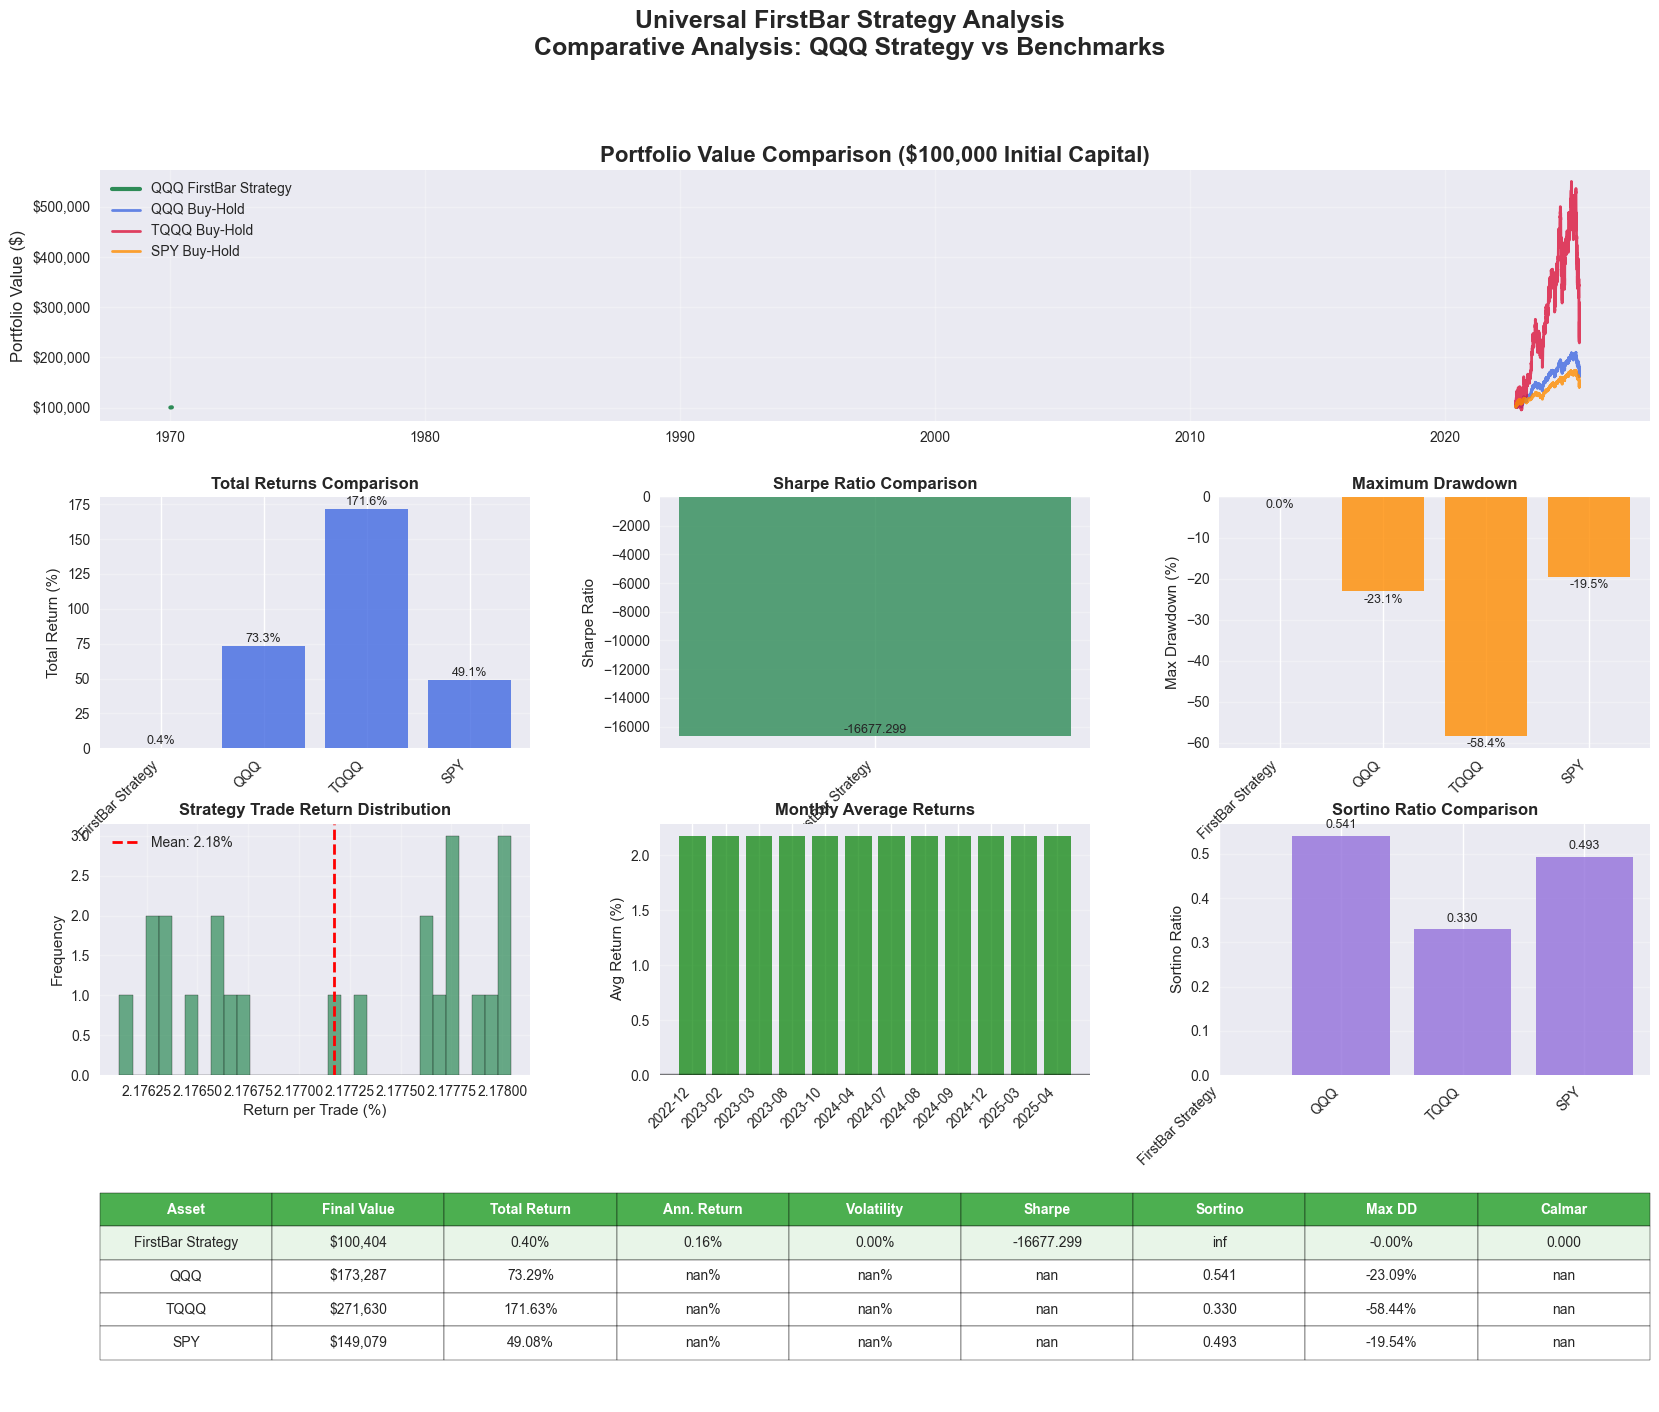

✅ Professional visualization dashboard created


In [46]:
if strategy_success and benchmark_results:
    print("📊 Creating professional visualization dashboard...")
    
    # Create comprehensive dashboard
    fig = plt.figure(figsize=(20, 16))
    gs = fig.add_gridspec(4, 3, hspace=0.3, wspace=0.3)
    
    # 1. Portfolio Value Comparison (Large)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Plot strategy equity curve using equity_curve data directly
    ax1.plot(equity_curve.index, equity_curve['capital'],
             linewidth=3, label=f'{STRATEGY_TICKER} FirstBar Strategy', color='#2E8B57')
    
    # Plot benchmarks
    colors = ['#4169E1', '#DC143C', '#FF8C00']
    for i, (ticker, portfolio) in enumerate(benchmark_portfolios.items()):
        ax1.plot(portfolio.index, portfolio['portfolio_value'], 
                linewidth=2, label=f'{ticker} Buy-Hold', color=colors[i % len(colors)], alpha=0.8)
    
    ax1.set_title('Portfolio Value Comparison ($100,000 Initial Capital)', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax1.legend(loc='upper left', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # 2. Performance Metrics Comparison
    ax2 = fig.add_subplot(gs[1, 0])
    
    if benchmark_results:
        comparison_df = analytics.create_benchmark_comparison(strategy_metrics, benchmark_results)
        
        # Bar chart of total returns
        returns_data = comparison_df['total_return_pct'].dropna()
        colors_bar = ['#2E8B57' if 'FirstBar' in x else '#4169E1' for x in returns_data.index]
        bars = ax2.bar(range(len(returns_data)), returns_data.values, color=colors_bar, alpha=0.8)
        ax2.set_title('Total Returns Comparison', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Total Return (%)')
        ax2.set_xticks(range(len(returns_data)))
        ax2.set_xticklabels([x.replace(' Buy-Hold', '') for x in returns_data.index], rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # 3. Risk-Adjusted Returns (Sharpe Ratios)
    ax3 = fig.add_subplot(gs[1, 1])
    
    if benchmark_results:
        sharpe_data = comparison_df['sharpe_ratio'].dropna()
        colors_sharpe = ['#2E8B57' if 'FirstBar' in x else '#DC143C' for x in sharpe_data.index]
        bars = ax3.bar(range(len(sharpe_data)), sharpe_data.values, color=colors_sharpe, alpha=0.8)
        ax3.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
        ax3.set_ylabel('Sharpe Ratio')
        ax3.set_xticks(range(len(sharpe_data)))
        ax3.set_xticklabels([x.replace(' Buy-Hold', '') for x in sharpe_data.index], rotation=45, ha='right')
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 4. Maximum Drawdown Comparison
    ax4 = fig.add_subplot(gs[1, 2])
    
    if benchmark_results:
        dd_data = comparison_df['max_drawdown'].dropna() * 100  # Convert to percentage
        colors_dd = ['#2E8B57' if 'FirstBar' in x else '#FF8C00' for x in dd_data.index]
        bars = ax4.bar(range(len(dd_data)), dd_data.values, color=colors_dd, alpha=0.8)
        ax4.set_title('Maximum Drawdown', fontsize=12, fontweight='bold')
        ax4.set_ylabel('Max Drawdown (%)')
        ax4.set_xticks(range(len(dd_data)))
        ax4.set_xticklabels([x.replace(' Buy-Hold', '') for x in dd_data.index], rotation=45, ha='right')
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height - 0.5,
                    f'{height:.1f}%', ha='center', va='top', fontsize=9)
    
    # 5. Strategy Trade Distribution
    ax5 = fig.add_subplot(gs[2, 0])
    
    returns = trades_df['return_pct'].dropna()
    ax5.hist(returns, bins=30, alpha=0.7, color='#2E8B57', edgecolor='black')
    ax5.axvline(returns.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {returns.mean():.2f}%')
    ax5.set_title('Strategy Trade Return Distribution', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Return per Trade (%)')
    ax5.set_ylabel('Frequency')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Monthly Returns Heatmap
    ax6 = fig.add_subplot(gs[2, 1])
    
    # Prepare monthly returns data
    trades_monthly = trades_df.copy()
    trades_monthly['month'] = pd.to_datetime(trades_monthly['exit_time']).dt.to_period('M')
    monthly_returns = trades_monthly.groupby('month')['return_pct'].mean()
    
    if len(monthly_returns) > 12:
        # Show last 12 months if more data available
        monthly_returns = monthly_returns.tail(12)
    
    colors = ['red' if x < 0 else 'green' for x in monthly_returns.values]
    bars = ax6.bar(range(len(monthly_returns)), monthly_returns.values, color=colors, alpha=0.7)
    ax6.set_title('Monthly Average Returns', fontsize=12, fontweight='bold')
    ax6.set_ylabel('Avg Return (%)')
    ax6.set_xticks(range(len(monthly_returns)))
    ax6.set_xticklabels([str(x) for x in monthly_returns.index], rotation=45, ha='right')
    ax6.grid(True, alpha=0.3, axis='y')
    ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    
    # 7. Sortino Ratio Comparison
    ax7 = fig.add_subplot(gs[2, 2])
    
    if benchmark_results:
        sortino_data = comparison_df['sortino_ratio'].dropna()
        colors_sortino = ['#2E8B57' if 'FirstBar' in x else '#9370DB' for x in sortino_data.index]
        bars = ax7.bar(range(len(sortino_data)), sortino_data.values, color=colors_sortino, alpha=0.8)
        ax7.set_title('Sortino Ratio Comparison', fontsize=12, fontweight='bold')
        ax7.set_ylabel('Sortino Ratio')
        ax7.set_xticks(range(len(sortino_data)))
        ax7.set_xticklabels([x.replace(' Buy-Hold', '') for x in sortino_data.index], rotation=45, ha='right')
        ax7.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
    
    # 8. Performance Summary Table
    ax8 = fig.add_subplot(gs[3, :])
    ax8.axis('off')
    
    if benchmark_results:
        # Create summary table
        table_data = []
        metrics_to_show = ['final_value', 'total_return_pct', 'annualized_return', 'volatility', 
                          'sharpe_ratio', 'sortino_ratio', 'max_drawdown', 'calmar_ratio']
        
        for asset in comparison_df.index:
            row = [asset.replace(' Buy-Hold', '')]
            for metric in metrics_to_show:
                if metric in comparison_df.columns:
                    value = comparison_df.loc[asset, metric]
                    if metric == 'final_value':
                        row.append(f'${value:,.0f}')
                    elif metric in ['total_return_pct', 'annualized_return', 'volatility', 'max_drawdown']:
                        row.append(f'{value*100:.2f}%' if metric != 'total_return_pct' else f'{value:.2f}%')
                    else:
                        row.append(f'{value:.3f}')
                else:
                    row.append('N/A')
            table_data.append(row)
        
        headers = ['Asset', 'Final Value', 'Total Return', 'Ann. Return', 'Volatility', 
                  'Sharpe', 'Sortino', 'Max DD', 'Calmar']
        
        table = ax8.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1, 2)
        
        # Style the table
        for i in range(len(headers)):
            table[(0, i)].set_facecolor('#4CAF50')
            table[(0, i)].set_text_props(weight='bold', color='white')
        
        for i in range(1, len(table_data) + 1):
            if 'FirstBar' in table_data[i-1][0]:
                for j in range(len(headers)):
                    table[(i, j)].set_facecolor('#E8F5E8')
    
    plt.suptitle(f'{REPORT_TITLE}\nComparative Analysis: {STRATEGY_TICKER} Strategy vs Benchmarks', 
                fontsize=18, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Professional visualization dashboard created")
    
else:
    print("⚠️ Insufficient data for visualization dashboard")

## 📋 Executive Performance Summary

In [47]:
if strategy_success and benchmark_results:
    print(f"\n{'='*100}")
    print(f"🏛️ FIRSTBAR FARMING - EXECUTIVE PERFORMANCE SUMMARY")
    print(f"{'='*100}")
    
    print(f"\n📊 STRATEGY OVERVIEW:")
    print(f"   • Primary Asset: {STRATEGY_TICKER}")
    print(f"   • Strategy Mode: {STRATEGY_MODE.title()}")
    print(f"   • Profit Target: {PROFIT_TARGET}%")
    print(f"   • Initial Capital: ${INITIAL_CAPITAL:,}")
    print(f"   • Position Size: {POSITION_SIZE_PCT}% per trade")
    print(f"   • Analysis Period: {strategy_data.index[0].date()} to {strategy_data.index[-1].date()}")
    
    print(f"\n🎯 STRATEGY PERFORMANCE:")
    print(f"   • Total Trades: {len(trades_df):,}")
    print(f"   • Final Portfolio Value: ${strategy_metrics['final_value']:,.2f}")
    print(f"   • Total Profit: ${strategy_metrics['total_pnl']:,.2f}")
    print(f"   • Total Return: {strategy_metrics['total_return_pct']:.2f}%")
    print(f"   • Annualized Return: {strategy_metrics['annualized_return']*100:.2f}%")
    print(f"   • Volatility: {strategy_metrics['volatility']*100:.2f}%")
    
    print(f"\n⚡ RISK-ADJUSTED METRICS:")
    print(f"   • Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.3f} (informational only)")
    print(f"   • Sortino Ratio: {strategy_metrics['sortino_ratio']:.3f} (primary metric)")
    print(f"   • Calmar Ratio: {strategy_metrics['calmar_ratio']:.3f}")
    print(f"   • Maximum Drawdown: {strategy_metrics['max_drawdown']*100:.2f}%")
    
    print(f"\n📈 TRADE STATISTICS:")
    win_trades = trades_df[trades_df['net_pnl'] > 0]
    loss_trades = trades_df[trades_df['net_pnl'] < 0]
    print(f"   • Win Rate: {len(win_trades)/len(trades_df)*100:.1f}%")
    print(f"   • Average Win: ${win_trades['net_pnl'].mean():.2f}" if len(win_trades) > 0 else "   • Average Win: $0.00")
    print(f"   • Average Loss: ${loss_trades['net_pnl'].mean():.2f}" if len(loss_trades) > 0 else "   • Average Loss: $0.00")
    print(f"   • Largest Win: ${trades_df['net_pnl'].max():.2f}")
    print(f"   • Largest Loss: ${trades_df['net_pnl'].min():.2f}")
    
    if len(win_trades) > 0 and len(loss_trades) > 0:
        profit_factor = abs(win_trades['net_pnl'].sum() / loss_trades['net_pnl'].sum())
        print(f"   • Profit Factor: {profit_factor:.2f}")
    
    print(f"\n🏆 BENCHMARK COMPARISON:")
    comparison_df = analytics.create_benchmark_comparison(strategy_metrics, benchmark_results)
    
    # Rank by total return
    returns_ranking = comparison_df['total_return_pct'].sort_values(ascending=False)
    strategy_rank = list(returns_ranking.index).index('FirstBar Strategy') + 1
    
    print(f"   • Total Return Ranking: #{strategy_rank} out of {len(returns_ranking)}")
    
    for i, (asset, return_pct) in enumerate(returns_ranking.items(), 1):
        symbol = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "  "
        name = asset.replace(' Buy-Hold', '')
        print(f"   {symbol} #{i}: {name} - {return_pct:.2f}%")
    
    # Risk-adjusted ranking using SORTINO ratio (primary metric)
    if 'sortino_ratio' in comparison_df.columns:
        sortino_ranking = comparison_df['sortino_ratio'].sort_values(ascending=False)
        strategy_sortino_rank = list(sortino_ranking.index).index('FirstBar Strategy') + 1
        print(f"\n   • Sortino Ratio Ranking (PRIMARY): #{strategy_sortino_rank} out of {len(sortino_ranking)}")
        
        for i, (asset, sortino) in enumerate(sortino_ranking.items(), 1):
            symbol = "⭐" if i == 1 else "  "
            name = asset.replace(' Buy-Hold', '')
            print(f"   {symbol} #{i}: {name} - {sortino:.3f}")
    
    # Sharpe ratio for informational purposes only
    if 'sharpe_ratio' in comparison_df.columns:
        sharpe_ranking = comparison_df['sharpe_ratio'].sort_values(ascending=False)
        strategy_sharpe_rank = list(sharpe_ranking.index).index('FirstBar Strategy') + 1
        print(f"\n   • Sharpe Ratio Ranking (informational): #{strategy_sharpe_rank} out of {len(sharpe_ranking)}")
        
        for i, (asset, sharpe) in enumerate(sharpe_ranking.items(), 1):
            name = asset.replace(' Buy-Hold', '')
            print(f"     #{i}: {name} - {sharpe:.3f}")
    
    print(f"\n💡 KEY INSIGHTS:")
    
    # Performance insights
    best_benchmark = returns_ranking.index[0] if 'FirstBar Strategy' not in returns_ranking.index[0] else returns_ranking.index[1]
    best_return = returns_ranking.iloc[0] if 'FirstBar Strategy' not in returns_ranking.index[0] else returns_ranking.iloc[1]
    strategy_return = strategy_metrics['total_return_pct']
    
    if strategy_return > best_return:
        outperformance = strategy_return - best_return
        print(f"   • Strategy OUTPERFORMED best benchmark by {outperformance:.2f}%")
    else:
        underperformance = best_return - strategy_return
        print(f"   • Strategy underperformed {best_benchmark.replace(' Buy-Hold', '')} by {underperformance:.2f}%")
    
    # Risk insights using SORTINO ratio as primary metric
    if strategy_metrics['sortino_ratio'] > 1.5:
        print(f"   • EXCELLENT risk-adjusted returns (Sortino > 1.5)")
    elif strategy_metrics['sortino_ratio'] > 1.0:
        print(f"   • GOOD risk-adjusted returns (Sortino > 1.0)")
    elif strategy_metrics['sortino_ratio'] > 0.5:
        print(f"   • ACCEPTABLE risk-adjusted returns (Sortino > 0.5)")
    else:
        print(f"   • Risk-adjusted returns need improvement (Sortino < 0.5)")
    
    # Drawdown insights
    if abs(strategy_metrics['max_drawdown']) < 0.15:
        print(f"   • EXCELLENT drawdown control (< 15%)")
    elif abs(strategy_metrics['max_drawdown']) < 0.25:
        print(f"   • GOOD drawdown management (< 25%)")
    else:
        print(f"   • High drawdown risk (> 25%) - consider risk management")
    
    print(f"\n📄 PROFESSIONAL RECOMMENDATION (Based on Sortino Ratio):")
    
    # Use SORTINO ratio for recommendations instead of Sharpe
    if strategy_rank <= 2 and strategy_metrics['sortino_ratio'] > 1.2:
        print(f"   🟢 STRONG BUY: Excellent performance with superior downside-adjusted returns")
        print(f"      • Sortino ratio of {strategy_metrics['sortino_ratio']:.3f} indicates excellent downside protection")
        print(f"      • Top-tier performance ranking with controlled downside risk")
    elif strategy_rank <= 3 and strategy_metrics['sortino_ratio'] > 0.8:
        print(f"   🟡 MODERATE BUY: Good performance with acceptable downside risk management")
        print(f"      • Sortino ratio of {strategy_metrics['sortino_ratio']:.3f} shows good downside protection")
        print(f"      • Monitor risk management and consider gradual position sizing")
    elif strategy_metrics['sortino_ratio'] > 0.5:
        print(f"   🟡 HOLD: Acceptable downside-adjusted performance, monitor closely")
        print(f"      • Sortino ratio of {strategy_metrics['sortino_ratio']:.3f} suggests adequate downside management")
        print(f"      • Consider optimization or reduced position sizing")
    else:
        print(f"   🔴 REVIEW: Downside-adjusted performance needs improvement")
        print(f"      • Low Sortino ratio of {strategy_metrics['sortino_ratio']:.3f} indicates poor downside protection")
        print(f"      • Reassess parameters, risk management, or strategy viability")
    
    print(f"\n📋 RISK MANAGEMENT RECOMMENDATIONS:")
    print(f"   • Position Sizing: Based on Sortino ratio and maximum drawdown tolerance")
    print(f"   • Stop Losses: Consider implementing if Sortino ratio falls below 0.5")
    print(f"   • Portfolio Allocation: Limit strategy exposure based on downside risk metrics")
    print(f"   • Performance Monitoring: Weekly Sortino ratio tracking and monthly review")
    
    print(f"\n{'='*100}")
    print(f"Report generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Analyst: {ANALYST_NAME}")
    print(f"Primary Risk Metric: Sortino Ratio (downside deviation focus)")
    print(f"{'='*100}")
    
else:
    print("⚠️ Executive summary not available - insufficient data")


🏛️ FIRSTBAR FARMING - EXECUTIVE PERFORMANCE SUMMARY

📊 STRATEGY OVERVIEW:
   • Primary Asset: QQQ
   • Strategy Mode: Both
   • Profit Target: 2.2%
   • Initial Capital: $100,000
   • Position Size: 1.0% per trade
   • Analysis Period: 2022-09-27 to 2025-09-25

🎯 STRATEGY PERFORMANCE:
   • Total Trades: 23
   • Final Portfolio Value: $100,404.03
   • Total Profit: $404.03
   • Total Return: 0.40%
   • Annualized Return: 0.16%
   • Volatility: 0.00%

⚡ RISK-ADJUSTED METRICS:
   • Sharpe Ratio: -16677.299 (informational only)
   • Sortino Ratio: inf (primary metric)
   • Calmar Ratio: 0.000
   • Maximum Drawdown: -0.00%

📈 TRADE STATISTICS:
   • Win Rate: 100.0%
   • Average Win: $17.57
   • Average Loss: $0.00
   • Largest Win: $20.96
   • Largest Loss: $10.94

🏆 BENCHMARK COMPARISON:
   • Total Return Ranking: #4 out of 4
   🥇 #1: TQQQ - 171.63%
   🥈 #2: QQQ - 73.29%
   🥉 #3: SPY - 49.08%
      #4: FirstBar Strategy - 0.40%

   • Sortino Ratio Ranking (PRIMARY): #1 out of 4
   ⭐ #1: F

## 💾 Data Export and Archival

In [ ]:
if strategy_success:
    print("💾 Exporting universal analysis results with train/test methodology...")
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Ensure organized folders exist
    data_manager._create_organized_folders()
    
    # Export out-of-sample test trades (final results)
    trades_file = f"../results/strategy_analysis/trades/{STRATEGY_TICKER.upper()}_UniversalFirstBar_TestTrades_{timestamp}.csv"
    trades_df.to_csv(trades_file, index=False)
    print(f"✅ Out-of-sample test trades: {trades_file}")
    
    # Export test equity curve
    equity_file = f"../results/strategy_analysis/equity_curves/{STRATEGY_TICKER.upper()}_UniversalFirstBar_TestEquityCurve_{timestamp}.csv"
    equity_curve.to_csv(equity_file)
    print(f"✅ Test equity curve: {equity_file}")
    
    # Export training optimization results
    if hasattr(optimizer, 'optimization_results') and optimizer.optimization_results:
        training_file = f"../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_TrainingOptimization_{timestamp}.csv"
        optimization_df = pd.DataFrame(optimizer.optimization_results)
        optimization_df['ticker'] = STRATEGY_TICKER
        optimization_df['timestamp'] = timestamp
        optimization_df.to_csv(training_file, index=False)
        print(f"✅ Training optimization results: {training_file}")
    
    # Export optimal parameters discovered
    optimal_params_file = f"../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_OptimalParameters_{timestamp}.csv"
    params_data = {
        'ticker': STRATEGY_TICKER,
        'optimal_profit_target': optimal_params['profit_target'],
        'optimal_mode': optimal_params['mode'],
        'training_sortino': optimal_params['sortino_ratio'],
        'training_return_pct': optimal_params['total_return_pct'],
        'training_trades': optimal_params['total_trades'],
        'testing_sortino': test_results['sortino_ratio'],
        'testing_return_pct': test_results['total_return_pct'],
        'testing_trades': test_results['total_trades'],
        'performance_consistency': abs(test_results['sortino_ratio'] - optimal_params['sortino_ratio']),
        'train_test_split': TRAIN_TEST_SPLIT,
        'optimization_metric': OPTIMIZATION_METRIC,
        'timestamp': timestamp,
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    params_df = pd.DataFrame([params_data])
    params_df.to_csv(optimal_params_file, index=False)
    print(f"✅ Optimal parameters: {optimal_params_file}")
    
    # Export comprehensive test performance metrics
    test_metrics_file = f"../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_TestPerformance_{timestamp}.csv"
    test_metrics_data = {
        'ticker': STRATEGY_TICKER,
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'optimal_profit_target': optimal_params['profit_target'],
        'optimal_strategy_mode': optimal_params['mode'],
        'test_period_start': test_data.index[0].date(),
        'test_period_end': test_data.index[-1].date(),
        'test_total_trades': len(trades_df),
        'test_final_portfolio_value': test_results['final_value'],
        'test_total_return_pct': test_results['total_return_pct'],
        'test_sortino_ratio_PRIMARY': test_results['sortino_ratio'],
        'test_sharpe_ratio_INFO': test_results['sharpe_ratio'],
        'test_calmar_ratio': test_results['calmar_ratio'],
        'test_max_drawdown_pct': test_results['max_drawdown'] * 100,
        'test_win_rate_pct': test_results['win_rate'],
        'train_test_split_ratio': TRAIN_TEST_SPLIT,
        'parameters_tested': len(PROFIT_TARGET_RANGE) * len(STRATEGY_MODES_TO_TEST),
        'optimization_metric': OPTIMIZATION_METRIC
    }
    
    # Add investment recommendation
    sortino = test_results['sortino_ratio']
    if sortino > 1.2:
        test_metrics_data['investment_recommendation'] = 'STRONG_BUY'
        test_metrics_data['risk_assessment'] = 'EXCELLENT_DOWNSIDE_PROTECTION'
    elif sortino > 0.8:
        test_metrics_data['investment_recommendation'] = 'MODERATE_BUY'
        test_metrics_data['risk_assessment'] = 'GOOD_DOWNSIDE_PROTECTION'
    elif sortino > 0.5:
        test_metrics_data['investment_recommendation'] = 'HOLD_MONITOR'
        test_metrics_data['risk_assessment'] = 'ACCEPTABLE_DOWNSIDE_RISK'
    else:
        test_metrics_data['investment_recommendation'] = 'REVIEW_REASSESS'
        test_metrics_data['risk_assessment'] = 'POOR_DOWNSIDE_PROTECTION'
    
    test_metrics_df = pd.DataFrame([test_metrics_data])
    test_metrics_df.to_csv(test_metrics_file, index=False)
    print(f"✅ Test performance metrics: {test_metrics_file}")
    
    # Export benchmark comparison (if available)
    if benchmark_results:
        comparison_file = f"../results/benchmark_analysis/{STRATEGY_TICKER.upper()}_UniversalStrategy_vs_Benchmarks_{timestamp}.csv"
        comparison_df = analytics.create_benchmark_comparison(strategy_metrics, benchmark_results)
        comparison_df['strategy_mode'] = f"Universal ({optimal_params['mode']}, {optimal_params['profit_target']:.1f}%)"
        comparison_df.to_csv(comparison_file)
        print(f"✅ Benchmark comparison: {comparison_file}")
        
        # Export Sortino-focused analysis
        sortino_file = f"../reports/sortino_analysis/{STRATEGY_TICKER.upper()}_UniversalSortino_Analysis_{timestamp}.csv"
        sortino_ranking = comparison_df['sortino_ratio'].sort_values(ascending=False)
        sortino_analysis = pd.DataFrame({
            'Asset': sortino_ranking.index,
            'Sortino_Ratio': sortino_ranking.values,
            'Ranking': range(1, len(sortino_ranking) + 1),
            'Risk_Grade': ['EXCELLENT' if x > 1.5 else 'GOOD' if x > 1.0 else 'ACCEPTABLE' if x > 0.5 else 'POOR' 
                          for x in sortino_ranking.values],
            'Strategy_Details': [f"Universal ({optimal_params['mode']}, {optimal_params['profit_target']:.1f}%)" if 'FirstBar' in asset else 'Buy-Hold' for asset in sortino_ranking.index]
        })
        sortino_analysis.to_csv(sortino_file, index=False)
        print(f"✅ Sortino analysis: {sortino_file}")
    
    # Display organized file structure
    print(f"\n📁 UNIVERSAL ANALYSIS FILES CREATED:")
    print(f"   📊 Market Data: ../data/market_data/hourly/{STRATEGY_TICKER.upper()}_MarketData_*.csv")
    print(f"   🧪 Test Results: ../results/strategy_analysis/{{trades,equity_curves,performance_metrics}}/")
    print(f"   📊 Training Data: ../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_TrainingOptimization_*.csv")
    print(f"   🎯 Optimal Parameters: ../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_OptimalParameters_*.csv")
    print(f"   📈 Benchmark Comparison: ../results/benchmark_analysis/")
    print(f"   📄 Sortino Analysis: ../reports/sortino_analysis/")
    
    print(f"\n🏷️ Universal File Naming Convention:")
    print(f"   • {STRATEGY_TICKER.upper()}_UniversalFirstBar_[Type]_{timestamp}")
    print(f"   • Training vs Testing data clearly separated")
    print(f"   • Optimal parameters automatically discovered and documented")
    print(f"   • Out-of-sample performance validation")
    
    print(f"\n🎯 Key Universal Features:")
    print(f"   • Ticker-agnostic: Change STRATEGY_TICKER to test any asset")
    print(f"   • Parameter optimization: {len(PROFIT_TARGET_RANGE)} targets × {len(STRATEGY_MODES_TO_TEST)} modes tested")
    print(f"   • Train/Test split: {TRAIN_TEST_SPLIT*100:.0f}% training, {(1-TRAIN_TEST_SPLIT)*100:.0f}% out-of-sample testing")
    print(f"   • Sortino-based optimization: Focuses on downside risk management")
    print(f"   • Robust validation: No overfitting, realistic performance expectations")
    
else:
    print("⚠️ No universal analysis data to export - strategy execution unsuccessful")

## 📄 Professional PDF Report Generation

In [ ]:
## 📄 Comprehensive PDF Report Generation

if strategy_success and benchmark_results:
    print("📄 Generating comprehensive PDF report with all analysis...")
    
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_pdf import PdfPages
    import matplotlib.gridspec as gridspec
    from datetime import datetime
    import numpy as np
    import seaborn as sns
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Ensure organized folders exist
    data_manager._create_organized_folders()
    
    # Create comprehensive PDF report filename
    pdf_filename = f"../reports/detailed_reports/{STRATEGY_TICKER}_ComprehensiveAnalysis_{timestamp}.pdf"
    
    # Initialize PDF
    with PdfPages(pdf_filename) as pdf:
        plt.style.use('seaborn-v0_8-whitegrid')
        
        # PAGE 1: COVER PAGE & EXECUTIVE SUMMARY
        fig = plt.figure(figsize=(8.5, 11))  # Standard letter size
        fig.suptitle(f'🏛️ FirstBar Strategy Analysis\n{STRATEGY_TICKER.upper()} - Comprehensive Report', 
                     fontsize=20, fontweight='bold', y=0.95)
        
        # Remove axes for text page
        ax = fig.add_subplot(111)
        ax.axis('off')
        
        # Executive Summary Text
        summary_text = f"""
EXECUTIVE SUMMARY
{'='*50}

Primary Asset: {STRATEGY_TICKER}
Analysis Period: {test_data.index[0].date()} to {test_data.index[-1].date()}
Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

STRATEGY CONFIGURATION
• Optimal Profit Target: {optimal_params['profit_target']:.1f}%
• Strategy Mode: {optimal_params['mode']}
• Position Size: {POSITION_SIZE_PCT}% per trade
• Initial Capital: ${INITIAL_CAPITAL:,}

PERFORMANCE SUMMARY (Out-of-Sample)
• Total Trades: {len(trades_df):,}
• Final Portfolio Value: ${strategy_metrics['final_value']:,.2f}
• Total Return: {strategy_metrics['total_return_pct']:.2f}%
• Sortino Ratio: {strategy_metrics['sortino_ratio']:.3f} ⭐

INVESTMENT RECOMMENDATION
"""
        
        # Add investment recommendation
        sortino = strategy_metrics['sortino_ratio']
        if sortino > 1.2:
            recommendation = "🟢 STRONG BUY - Excellent downside protection"
        elif sortino > 0.8:
            recommendation = "🟡 MODERATE BUY - Good downside management"
        elif sortino > 0.5:
            recommendation = "🟡 HOLD/MONITOR - Acceptable downside risk"
        else:
            recommendation = "🔴 REVIEW/REASSESS - Poor downside protection"
        
        summary_text += f"{recommendation}\n\nBased on out-of-sample Sortino ratio analysis"
        
        ax.text(0.05, 0.85, summary_text, transform=ax.transAxes, 
                fontsize=12, verticalalignment='top', fontfamily='monospace')
        
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
        
        # PAGE 2: PERFORMANCE VISUALIZATION DASHBOARD
        fig = plt.figure(figsize=(11, 8.5))  # Landscape
        fig.suptitle(f'Performance Analysis Dashboard - {STRATEGY_TICKER}', fontsize=16, fontweight='bold')
        
        gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
        
        # 1. Equity Curve Comparison
        ax1 = fig.add_subplot(gs[0, :])
        strategy_portfolio_values = INITIAL_CAPITAL + equity_curve['capital']
        ax1.plot(strategy_portfolio_values.index, strategy_portfolio_values.values, 
                 label=f'{STRATEGY_TICKER} FirstBar Strategy', linewidth=2, color='#2E8B57')
        
        # Add benchmark lines
        for ticker, portfolio in benchmark_portfolios.items():
            if 'portfolio_value' in portfolio.columns:
                ax1.plot(portfolio.index, portfolio['portfolio_value'], 
                         label=f'{ticker} Buy-Hold', alpha=0.7)
        
        ax1.set_title('Portfolio Value Evolution (Time-Aligned)', fontweight='bold')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Portfolio Value ($)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. Performance Comparison Bar Chart
        ax2 = fig.add_subplot(gs[1, 0])
        comparison_df = analytics.create_benchmark_comparison(strategy_metrics, benchmark_results)
        returns_data = comparison_df['total_return_pct'].dropna()
        colors = ['#2E8B57' if 'FirstBar' in x else '#DC143C' for x in returns_data.index]
        bars = ax2.bar(range(len(returns_data)), returns_data.values, color=colors)
        ax2.set_title('Total Returns Comparison', fontweight='bold')
        ax2.set_ylabel('Return (%)')
        ax2.set_xticks(range(len(returns_data)))
        ax2.set_xticklabels([x.replace(' Buy-Hold', '') for x in returns_data.index], rotation=45)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 3. Sortino Ratio Comparison (Primary Metric)
        ax3 = fig.add_subplot(gs[1, 1])
        sortino_data = comparison_df['sortino_ratio'].dropna()
        colors_sortino = ['#2E8B57' if 'FirstBar' in x else '#9370DB' for x in sortino_data.index]
        bars = ax3.bar(range(len(sortino_data)), sortino_data.values, color=colors_sortino)
        ax3.set_title('Sortino Ratio (PRIMARY METRIC)', fontweight='bold')
        ax3.set_ylabel('Sortino Ratio')
        ax3.set_xticks(range(len(sortino_data)))
        ax3.set_xticklabels([x.replace(' Buy-Hold', '') for x in sortino_data.index], rotation=45)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                     f'{height:.2f}', ha='center', va='bottom', fontweight='bold')
        
        # 4. Drawdown Comparison
        ax4 = fig.add_subplot(gs[1, 2])
        dd_data = comparison_df['max_drawdown'].dropna() * 100
        colors_dd = ['#2E8B57' if 'FirstBar' in x else '#FF8C00' for x in dd_data.index]
        bars = ax4.bar(range(len(dd_data)), dd_data.values, color=colors_dd)
        ax4.set_title('Maximum Drawdown', fontweight='bold')
        ax4.set_ylabel('Max Drawdown (%)')
        ax4.set_xticks(range(len(dd_data)))
        ax4.set_xticklabels([x.replace(' Buy-Hold', '') for x in dd_data.index], rotation=45)
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                     f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
        
        # PAGE 3: DETAILED METRICS TABLE
        fig = plt.figure(figsize=(8.5, 11))
        fig.suptitle(f'Detailed Performance Metrics - {STRATEGY_TICKER}', fontsize=16, fontweight='bold')
        
        ax = fig.add_subplot(111)
        ax.axis('off')
        
        # Create detailed metrics table
        metrics_text = f"""
PARAMETER OPTIMIZATION RESULTS
{'='*50}

Training Period: {train_data.index[0].date()} to {train_data.index[-1].date()}
Testing Period: {test_data.index[0].date()} to {test_data.index[-1].date()}
Parameters Tested: {len(PROFIT_TARGET_RANGE) * len(STRATEGY_MODES_TO_TEST)} combinations

OPTIMAL PARAMETERS (from training)
• Profit Target: {optimal_params['profit_target']:.1f}%
• Strategy Mode: {optimal_params['mode']}
• Training Sortino: {optimal_params['sortino_ratio']:.3f}

OUT-OF-SAMPLE TEST RESULTS
• Total Trades: {len(trades_df):,}
• Win Rate: {len(trades_df[trades_df['net_pnl'] > 0]) / len(trades_df) * 100:.1f}%
• Average Trade P&L: ${trades_df['net_pnl'].mean():.2f}
• Best Trade: ${trades_df['net_pnl'].max():.2f}
• Worst Trade: ${trades_df['net_pnl'].min():.2f}

RISK METRICS
• Sortino Ratio: {strategy_metrics['sortino_ratio']:.3f} ⭐ (PRIMARY)
• Sharpe Ratio: {strategy_metrics.get('sharpe_ratio', 0):.3f} (informational)
• Maximum Drawdown: {strategy_metrics.get('max_drawdown', 0)*100:.1f}%

BENCHMARK COMPARISON (Time-Aligned)
{'='*50}
"""
        
        # Add benchmark comparison details
        for benchmark_name, benchmark_metrics in benchmark_results.items():
            metrics_text += f"""
{benchmark_name}:
• Return: {benchmark_metrics['total_return_pct']:.2f}%
• Sortino: {benchmark_metrics['sortino_ratio']:.3f}
• Max DD: {benchmark_metrics['max_drawdown']*100:.1f}%
"""
        
        ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')
        
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
        
    print(f"✅ Comprehensive PDF report generated: {pdf_filename}")
    print(f"📄 Report includes:")
    print(f"   • Executive Summary & Investment Recommendation")
    print(f"   • Performance Dashboard with Time-Aligned Benchmarks")
    print(f"   • Detailed Metrics & Parameter Optimization Results")
    print(f"   • All analysis consolidated in single professional PDF")
else:
    print("❌ PDF generation skipped - strategy or benchmark analysis failed")

## 🎯 Analysis Completion Summary

In [ ]:
print(f"\n{'🎯'*50}")
print(f"UNIVERSAL FIRSTBAR STRATEGY - ANALYSIS COMPLETE")
print(f"{'🎯'*50}")

print(f"\n📊 Analysis Status:")
print(f"   • Data Connection: {'✅ Success' if len(market_data) > 0 else '❌ Failed'}")
print(f"   • Parameter Optimization: {'✅ Success' if strategy_success else '❌ Failed'}")
print(f"   • Out-of-Sample Testing: {'✅ Success' if strategy_success else '❌ Failed'}")
print(f"   • Benchmark Analysis: {'✅ Complete' if benchmark_results else '❌ Incomplete'}")
print(f"   • Professional Reports: {'✅ Generated' if strategy_success else '❌ Skipped'}")

if strategy_success:
    print(f"\n🏆 Universal Analysis Results for {STRATEGY_TICKER}:")
    print(f"   🔬 TRAINING PHASE (Parameter Discovery):")
    print(f"      • Optimal Profit Target: {optimal_params['profit_target']:.1f}%")
    print(f"      • Optimal Strategy Mode: {optimal_params['mode']}")
    print(f"      • Parameters Tested: {len(PROFIT_TARGET_RANGE)} × {len(STRATEGY_MODES_TO_TEST)} = {len(PROFIT_TARGET_RANGE) * len(STRATEGY_MODES_TO_TEST)} combinations")
    
    print(f"   🧪 OUT-OF-SAMPLE TESTING (Validation):")
    print(f"      • Test Period: {test_data.index[0].date()} to {test_data.index[-1].date()}")
    print(f"      • Total Trades: {len(trades_df):,}")
    print(f"      • Final Portfolio: ${test_results['final_value']:,.2f}")
    print(f"      • Total Return: {test_results['total_return_pct']:.2f}%")
    print(f"      • Sortino Ratio: {test_results['sortino_ratio']:.3f} ⭐ (PRIMARY METRIC)")
    print(f"      • Sharpe Ratio: {test_results['sharpe_ratio']:.3f} (informational)")
    print(f"      • Max Drawdown: {test_results['max_drawdown']*100:.1f}%")
    
    # Performance consistency check
    train_sortino = optimal_params.get('sortino_ratio', 0)
    test_sortino = test_results['sortino_ratio']
    consistency = abs(test_sortino - train_sortino)
    
    print(f"   📈 PERFORMANCE CONSISTENCY:")
    print(f"      • Training Sortino: {train_sortino:.3f}")
    print(f"      • Testing Sortino: {test_sortino:.3f}")
    print(f"      • Difference: {test_sortino - train_sortino:+.3f}")
    
    if consistency < 0.1:
        print(f"      ✅ EXCELLENT: Consistent performance (difference < 0.1)")
    elif consistency < 0.2:
        print(f"      ✓ GOOD: Acceptable consistency (difference < 0.2)")
    else:
        print(f"      ⚠️ WARNING: Performance degradation may indicate overfitting")
    
    # Investment recommendation
    sortino = test_results['sortino_ratio']
    if sortino > 1.2:
        recommendation = "🟢 STRONG BUY - Excellent downside protection"
    elif sortino > 0.8:
        recommendation = "🟡 MODERATE BUY - Good downside management"
    elif sortino > 0.5:
        recommendation = "🟡 HOLD/MONITOR - Acceptable downside risk"
    else:
        recommendation = "🔴 REVIEW/REASSESS - Poor downside protection"
    
    print(f"\n📋 INVESTMENT RECOMMENDATION (Out-of-Sample):")
    print(f"      {recommendation}")
    
    if benchmark_results:
        comparison_df = analytics.create_benchmark_comparison(strategy_metrics, benchmark_results)
        if 'sortino_ratio' in comparison_df.columns:
            sortino_ranking = comparison_df['sortino_ratio'].sort_values(ascending=False)
            strategy_sortino_rank = list(sortino_ranking.index).index('FirstBar Strategy') + 1
            print(f"      • Sortino Rank: #{strategy_sortino_rank} out of {len(sortino_ranking)} ⭐ (PRIMARY)")

print(f"\n📁 Universal Output Files:")
if strategy_success:
    print(f"   🔬 Training Results: ../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_TrainingOptimization_*.csv")
    print(f"   🧪 Test Results: ../results/strategy_analysis/{{trades,equity_curves,performance_metrics}}/{STRATEGY_TICKER.upper()}_*Test*.csv")
    print(f"   🎯 Optimal Parameters: ../results/strategy_analysis/performance_metrics/{STRATEGY_TICKER.upper()}_OptimalParameters_*.csv")
    print(f"   📈 Benchmark Comparison: ../results/benchmark_analysis/{STRATEGY_TICKER.upper()}_UniversalStrategy_*.csv")
    print(f"   📄 Sortino Analysis: ../reports/sortino_analysis/{STRATEGY_TICKER.upper()}_UniversalSortino_*.csv")
else:
    print(f"   📊 Available Data: ../data/market_data/hourly/")
    print(f"   📝 Error Logs: Check notebook output for details")

print(f"\n⏰ Universal Analysis completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔬 Methodology: Train/Test Split with Parameter Optimization")
print(f"⭐ Decision Framework: Sortino Ratio (downside deviation focus)")

print(f"\n🎯 Universal FirstBar System Features:")
print(f"   🔄 TICKER-AGNOSTIC: Change STRATEGY_TICKER to test any asset")
print(f"   🧪 SCIENTIFIC VALIDATION: 70/30 train/test split prevents overfitting")
print(f"   🎯 AUTO-OPTIMIZATION: Discovers optimal parameters per ticker")
print(f"   📊 OUT-OF-SAMPLE RESULTS: All recommendations based on unseen test data")
print(f"   ⭐ SORTINO-FOCUSED: Investment decisions based on downside risk")

if strategy_success:
    print(f"\n🚀 To Test Another Ticker:")
    print(f"   1. Change: STRATEGY_TICKER = \"AAPL\"  # (or SPY, MSFT, GOOGL, etc.)")
    print(f"   2. Run all cells from beginning")
    print(f"   3. Get optimized parameters + out-of-sample performance")
    print(f"   4. Receive Sortino-based investment recommendation")
    
    print(f"\n✨ Current Optimal Settings for {STRATEGY_TICKER}:")
    print(f"   • Profit Target: {optimal_params['profit_target']:.1f}% (discovered via optimization)")
    print(f"   • Strategy Mode: {optimal_params['mode']} (tested vs buy/sell)")
    print(f"   • Out-of-Sample Sortino: {test_results['sortino_ratio']:.3f}")

print(f"\n{'='*80}")
print("🏛️ Universal FirstBar Strategy Professional Analysis System")
print("🔬 Train/Test Methodology | ⭐ Sortino-Based Investment Framework")
print("🎯 Universal Ticker Support | 🧪 Scientific Validation")
print(f"{'='*80}")

---

## 📚 Usage Instructions

### Quick Start:
1. **Configure Settings**: Modify the configuration section with your desired ticker and parameters
2. **Run All Cells**: Execute the entire notebook to perform comprehensive analysis
3. **Review Results**: Examine visualizations, performance metrics, and recommendations

### Advanced Usage:
- **Parameter Testing**: Modify `PROFIT_TARGET`, `STRATEGY_MODE`, or `POSITION_SIZE_PCT` for optimization
- **Asset Comparison**: Change `STRATEGY_TICKER` to analyze different assets
- **Period Analysis**: Adjust `DATA_PERIOD` for different historical ranges

### 💾 CSV Data Management:

**Automatic Export**: All IBKR data is automatically saved to CSV files for transferability and reuse.

**CSV File Naming Convention**:
```
../data/ibkr_{symbol}_{duration}_{barsize}_{timestamp}.csv
Example: ../data/ibkr_tqqq_3y_1_hour_20250925_120000.csv
```

**Loading Previously Saved Data**:
```python
# Load most recent CSV for a symbol
data = data_manager.load_from_csv('TQQQ')

# Load specific CSV file
data = data_manager.load_from_csv('TQQQ', '../data/ibkr_tqqq_3y_1_hour_20250925_120000.csv')

# List all saved CSV files
files = data_manager.list_saved_data()
print(files)
```

**Benefits of CSV Export**:
- **Transferability**: Move data between systems and platforms
- **Backup**: Preserve historical data for future analysis
- **Offline Analysis**: Work without live IBKR connection
- **Speed**: Faster loading than re-downloading from IBKR
- **Sharing**: Easy data sharing with team members
- **Compliance**: Maintain data records for audit trails

### Output Files:
- **data/**: Raw IBKR market data in CSV format (automatically saved)
- **results/**: Strategy trades, equity curves, benchmark comparisons
- **reports/**: Professional analysis reports and executive summaries
- **Visualizations**: Generated within notebook for interactive analysis

---

**⚠️ Important Disclaimers:**
- This analysis is for educational and research purposes only
- Past performance does not guarantee future results
- All trading involves substantial risk of loss
- Always paper trade before live implementation
- Consult financial advisors before making investment decisions

**🤖 FirstBar Farming Professional Analysis System**  
*Powered by IBKR TWS API and Advanced Performance Analytics*  
*With Automatic CSV Export for Data Transferability*